# **ASHRAE-Great Energy Predictor III**

# 1. Business Problem

There are significant investments been made to improve the energy efficiency of the buldings to reduce costs, emmisions and energy consumption. The building owner makes the payment based on the difference between the actual amount of energy being used and the amount which they had used without any efficiency improvement processes. The latter values comes from the machine learning model. Given the historic energy usage of more than 1400 buildings over a span of 1 year, predict the future energy usage. This will then be compared to the actual energy usage with efficiency process to understand the  cost and energy savings.

# 2. Mapping Business Problem to ML Problem

## 2.1 Data Overview:

We have 5 csv files.

**train.csv/test.csv**: Contains the building ids, meter ids, timestamp of when the meter measurement was taken and meter readings which is our target variable.

*building_id* - Foreign key for the building metadata.

*meter* - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.

*timestamp* - When the measurement was taken

*meter_reading* - The target variable. Energy consumption in kWh (or equivalent)

**weather_train.csv/weather_test.csv**: Weather data from metrological stations as close to the sites as possible.

*site_id*

*air_temperature* - Degrees Celsius

*cloud_coverage* - Portion of the sky covered in clouds, in oktas

*dew_temperature* - Degrees Celsius

*precip_depth_1_hr* - Millimeters

*sea_level_pressure* - Millibar/hectopascals

*wind_direction* - Compass direction (0-360)

*wind_speed* - Meters per second



**building_metadata.csv**: Building metadata for all the buildings of various sites. 

*site_id* - Foreign key for the weather files.

*building_id* - Foreign key for training.csv

*primary_use* - Indicator of the primary category of activities for the building based on EnergyStar property type definitions

*square_feet* - Gross floor area of the building

*year_built* - Year building was opened

*floor_count* - Number of floors of the building

## 2.2 Type of Machine Learning Problem:
We will approach this forecasting problem as a regression problem, given the energy consumption data at time t, we will predict the data at time t+1.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb

In [ ]:
#Loading the train data
train= pd.read_csv('/content/drive/MyDrive/Appliedai files/Case study 1/Data/train.csv')
weather_train= pd.read_csv('/content/drive/MyDrive/Appliedai files/Case study 1/Data/weather_train.csv')

In [ ]:
building= pd.read_csv('/content/drive/MyDrive/Appliedai files/Case study 1/Data/building_metadata.csv')

In [ ]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [ ]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [ ]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [ ]:
#Loading the test data
test= pd.read_csv('/content/drive/MyDrive/Appliedai files/Case study 1/Data/test.csv')
weather_test=pd.read_csv('/content/drive/MyDrive/Appliedai files/Case study 1/Data/weather_test.csv')

In [ ]:
test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [ ]:
weather_test.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [ ]:
#Shapes of the dataframes

print('Shape of train data:',train.shape)
print('Shape of weather train data:', weather_train.shape)
print('Shape of building meta data:', building.shape)
print('Shape of test data:', test.shape)
print('Shape of weather test data:', weather_test.shape)


Shape of train data: (20216100, 4)
Shape of weather train data: (139773, 9)
Shape of building meta data: (1449, 6)
Shape of test data: (41697600, 4)
Shape of weather test data: (277243, 9)


In [ ]:
#https://www.kaggle.com/kernels/scriptcontent/3684066/download

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    #iterating over every column and finding the type of the column
    for col in df.columns:
      if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
      col_type = df[col].dtype
        
        #If the columns is not object
      if col_type != object:
          #Get the minimum and maximum value
            c_min = df[col].min()
            c_max = df[col].max()
            #If the type is int
            if str(col_type)[:3] == 'int':
              #If the min max values lies with thin the range of int8 type then assign the type as int8
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
              #If the min max values lies with thin the range of int16 type then assign the type as int16 
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
              #If the min max values lies with thin the range of int32 type then assign the type as int32
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
              #If the min max values lies with thin the range of int64 type then assign the type as int64
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
              #If the min max values lies with thin the range of float16 type then assign the type as float16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
              #If the min max values lies with thin the range of float32 type then assign the type as float32
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
      else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [ ]:
train= reduce_mem_usage(train, use_float16=True)
weather_train= reduce_mem_usage(weather_train, use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


In [ ]:
test= reduce_mem_usage(test)
weather_test= reduce_mem_usage(weather_test)

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 5.25 MB
Decreased by 72.4%


In [ ]:
#We will combine the all the data for train set in a single dataframe and test set in another dataframe
train_df= train.merge(building, on='building_id', how='left')


In [ ]:
test_df= test.merge(building, on='building_id', how='left')

In [ ]:
train_df=train_df.merge(weather_train, on=['site_id', 'timestamp'], how='left')

In [ ]:
test_df=test_df.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [ ]:
test_df.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [ ]:
#Check null values
train_df.isnull().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64

In [ ]:
test_df.isnull().sum()

row_id                       0
building_id                  0
meter                        0
timestamp                    0
site_id                      0
primary_use                  0
square_feet                  0
year_built            24598080
floor_count           34444320
air_temperature         221901
cloud_coverage        19542180
dew_temperature         260799
precip_depth_1_hr      7801563
sea_level_pressure     2516826
wind_direction         2978663
wind_speed              302089
dtype: int64

As we can see we have a few columns with missing values. We will imputate them later, once we are done with EDA.

In [ ]:
#We will break the timestamp into hour of the day, day of the week and month of the year

def break_datetime(df):
  df['timestamp']= pd.to_datetime(df['timestamp'])
  df['hour']= np.uint8(df['timestamp'].dt.hour)
  df['dayofweek']= np.uint8(df['timestamp'].dt.dayofweek)
  df['month']= np.uint8(df['timestamp'].dt.month)
  df['dayofyear']= np.uint16(df['timestamp'].dt.dayofyear)
  df['day']= np.uint16(df['timestamp'].dt.day)
  df['year']= np.uint16(df['timestamp'].dt.year)
  return df

  train_df= break_datetime(train_df)


In [ ]:
train_df= break_datetime(train_df)

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016


In [ ]:
test_df= break_datetime(test_df)

## 3. Exploratory Data Analysis

In [ ]:
#checking the descriptive statistics for the target variable

train_df['meter_reading'].describe()

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [ ]:
sns.set_style('darkgrid')

### 3.1 Distribution plot: meter_reading

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


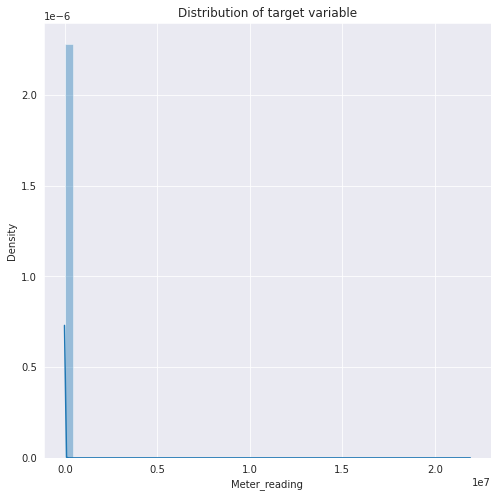

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['meter_reading'])
plt.xlabel("Meter_reading")
plt.title("Distribution of target variable")
plt.show()

As we can see our target variable heavily skewed and not much of insights can be gathered from the above plot. Hence we will use log transformation.

In [ ]:
train_df['meter_reading']=np.log1p(train_df['meter_reading'])

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


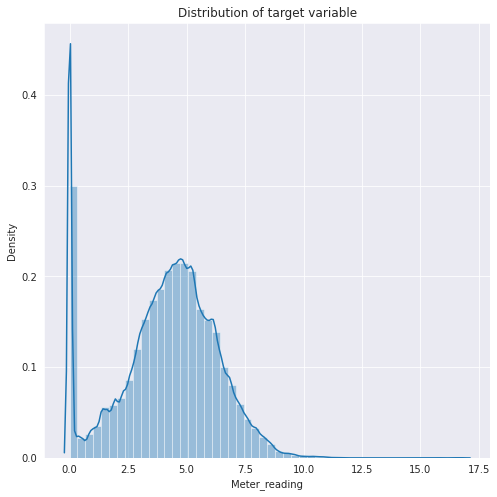

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['meter_reading'])
plt.xlabel("Meter_reading")
plt.title("Distribution of target variable")
plt.show()

We can see from the above plot that maximum readings are zero and has a good variance now after transformation.

In [ ]:
#Summary after transformations
train_df['meter_reading'].describe()

count    2.021610e+07
mean     4.208398e+00
std      2.074255e+00
min      0.000000e+00
25%      2.960105e+00
50%      4.379210e+00
75%      5.594652e+00
max      1.690221e+01
Name: meter_reading, dtype: float64

### 3.2 Average hourly reading

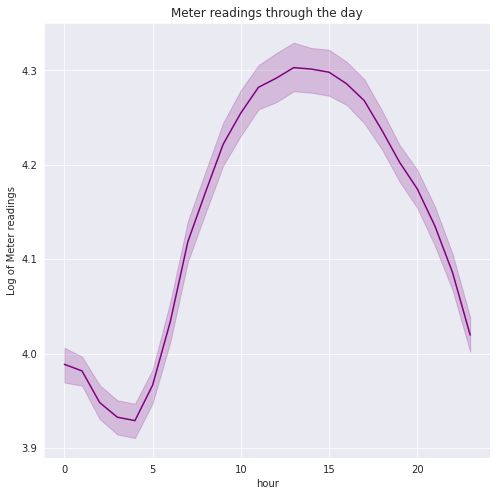

In [ ]:
#Lets check the hour wise usage of power
plt.figure(figsize=(8,8))
hour_df= train_df.groupby(['timestamp','hour']).meter_reading.mean().reset_index()
sns.lineplot(x=hour_df['hour'], y=hour_df['meter_reading'], color='purple')
plt.ylabel("Log of Meter readings")
plt.title("Meter readings through the day")
plt.show()

It can be observerd from the above plot that the meter readings drop in the early hours of the morning around 4am and rises again after 6am. The hourly usage peaks in the afternoon arpund 3pm. This behaviour is obvious as most of institutes, industries and other buildings are fully operational during this time.

### 3.3 Average Daily reading

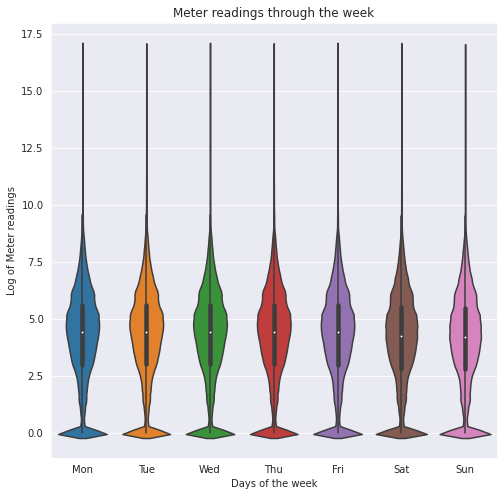

In [ ]:
#Lets check the day wise usage of power
plt.figure(figsize=(8,8))
day_labels= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
p=sns.violinplot(x=train_df['dayofweek'], y=train_df['meter_reading'], pallete='muted')
p.set_xticklabels(day_labels)
plt.xlabel("Days of the week")
plt.ylabel("Log of Meter readings")
plt.title("Meter readings through the week")
plt.show()

There is not much of a difference in day to day basis of usage. Still, sundays have the lowest usage as we know most of the companies and educational institutions are closed on sunday.

### 3.4 Average monthly usage

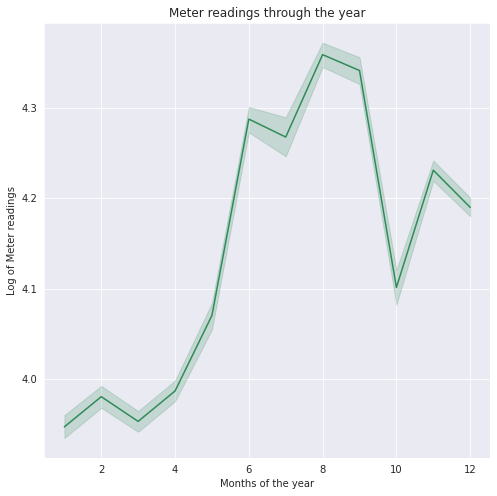

In [ ]:
#Lets check the month wise usage of power
plt.figure(figsize=(8,8))
month_df= train_df.groupby(['timestamp','month']).meter_reading.mean().reset_index()
sns.lineplot(x=month_df['month'], y=month_df['meter_reading'], color='seagreen')
plt.xlabel("Months of the year")
plt.ylabel("Log of Meter readings")
plt.title("Meter readings through the year")
plt.show()




The average monthly consumption is minimal in the initial months and then rises after April in the onset of spring. It peaks in August and starts dropping again in the Autumn and winter months.

In [ ]:
#lets specify the category names of meter id codes
train_df['meter'].replace({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}, inplace=True)

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
0,0,electricity,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
1,1,electricity,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
2,2,electricity,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
3,3,electricity,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
4,4,electricity,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016


### 3.5 Count plot for Meter types

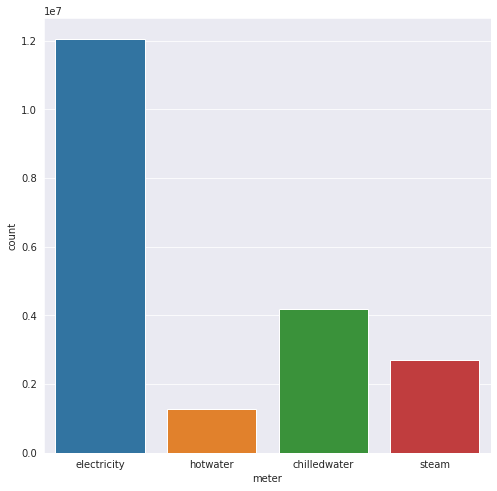

In [ ]:
#Count plot for each meter category
plt.figure(figsize=(8,8))
p=sns.countplot(x='meter', data=train_df)

We have the maximum meter readings for electricity followed by chilled water and steam. The lowest readings are for hotwater.

### 3.6 Average meter reading by meter types

Text(0.5, 1.0, 'Average meter readings by meter types')

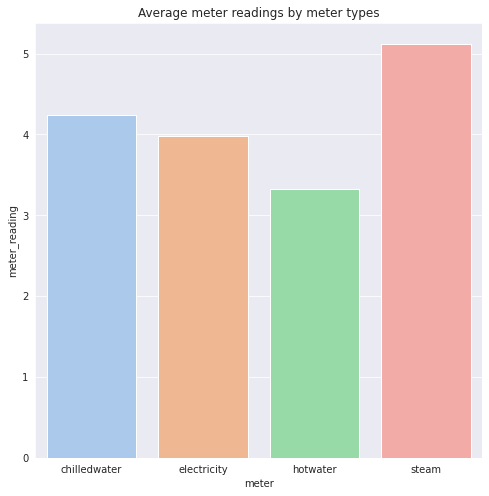

In [ ]:
#Meter readings for each meter category
plt.figure(figsize=(8,8))
meter_df= train_df.groupby('meter').meter_reading.mean().reset_index()
ax= sns.barplot(x='meter', y='meter_reading', data=meter_df, palette='pastel')
plt.title("Average meter readings by meter types")

Steam is the least energy eficient and hotwater is the most energy efficient.

### 3.7 Count plots of primary use

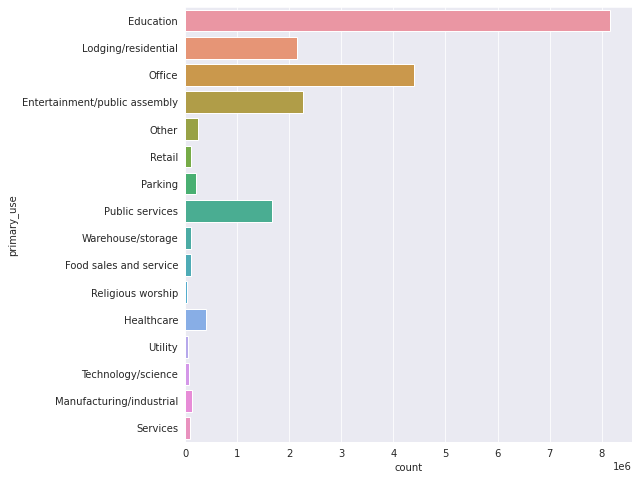

In [ ]:
#Primary usage plots
#Count plot for each primary usage category
plt.figure(figsize=(8,8))
sns.countplot(y='primary_use', data=train_df)

Most number of readings are present for educational institutes followed by office, enetertainment and Lodging/residential buildings.

### 3.8 Average hourly consumption by primary use

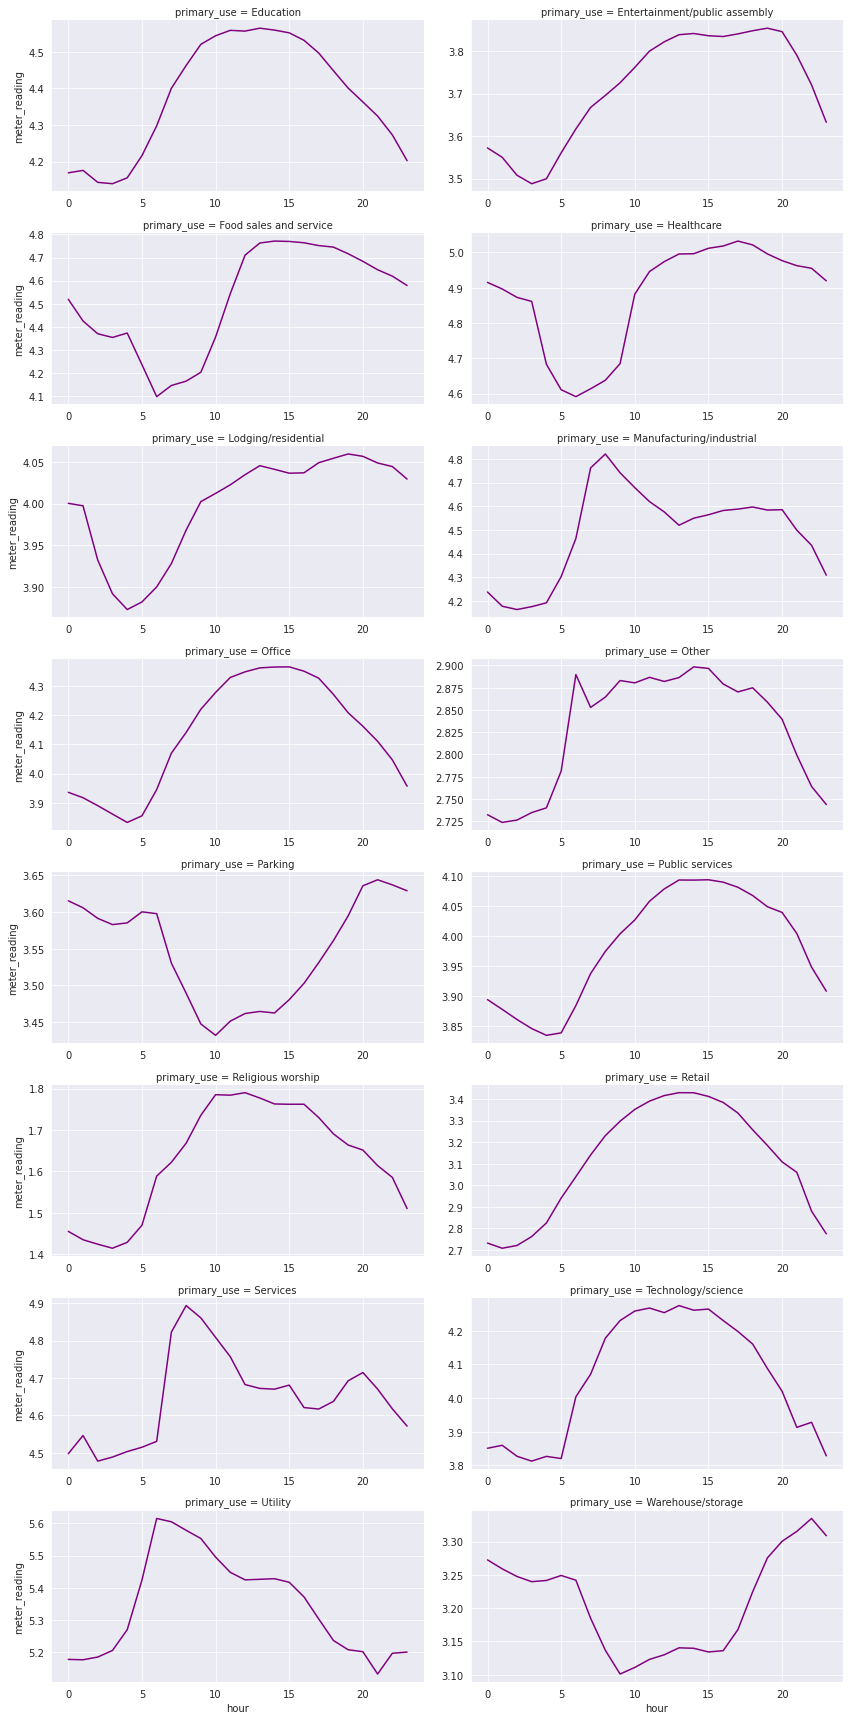

In [ ]:
#Hourly average readings based on type of buildings
hour_use_df= train_df.groupby(['hour', 'primary_use']).meter_reading.mean().reset_index()
p=sns.FacetGrid(hour_use_df, col='primary_use', col_wrap=2, height=3, aspect=2, sharey=False, sharex=False)
p.map(sns.lineplot, 'hour', 'meter_reading', color='purple')
plt.show()

In the above figure, we have plotted the average hourly usage for each of the primary usage category.



*   The peak usage for educational institutes have the peak usage from morning 9 am until 3 pm and then the usage drops. This is explained as most educational institutes are operational during day time only.
*   The consumption for enetertainmet as well as food sales buildings rises after 10 and and continues to remain stable until 8 pm.
*   The healthcare and residential buildings have a similar behavious of usage as it peaks around 4 pm and then drops in the evening.
*   The office buildings, retail, technology and public services buildings also consume most of the energy in the daytime mainly from 10 am to 4 pm.
*   The parkings have the minimum usage in th morning hours and the consumption rises after 3 pm.
*   The religious buildings consumes the least energy and utilities consume the most.










### 3.9 Average daily consumption by primary use

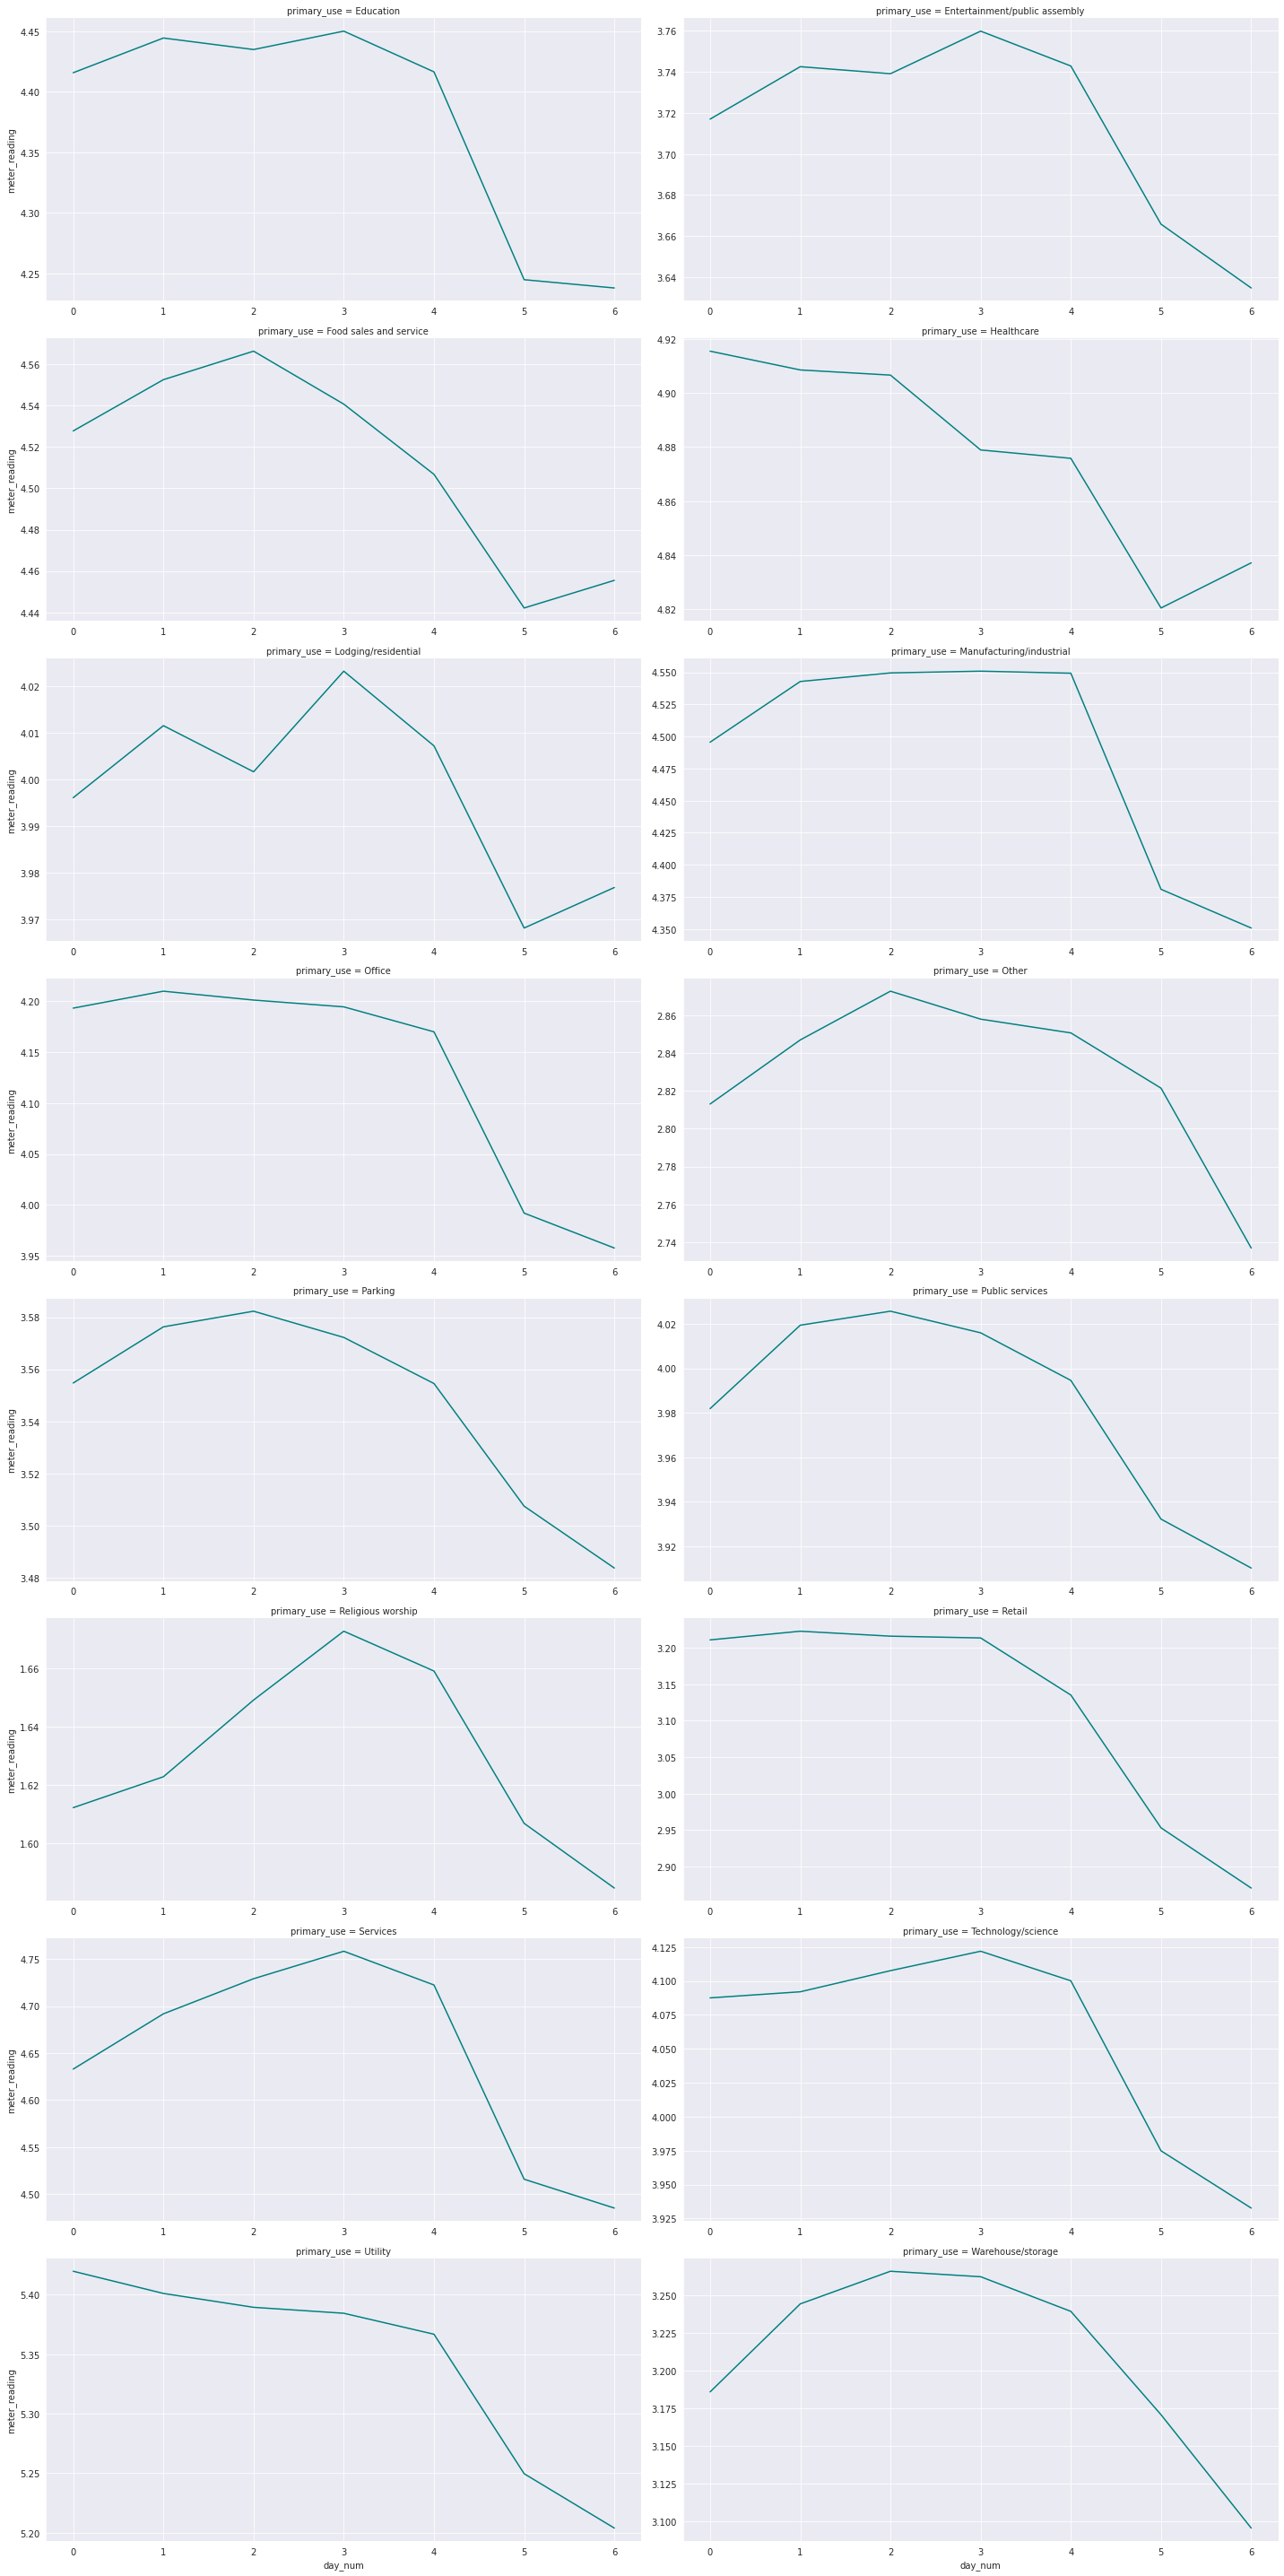

In [ ]:
#Daily average readings based on type of buildings
day_use_df= train_df.groupby(['day_num', 'primary_use']).meter_reading.mean().reset_index()
p=sns.FacetGrid(day_use_df, col='primary_use', col_wrap=2, height=5, aspect=2, sharey=False, sharex=False)
p.map(sns.lineplot, 'day_num', 'meter_reading', color='teal')
plt.show()

In the above figure, we have plotted the average daily
usage for each of the primary usage category. As we can see from the above plots, the average consumption is the lowest on sundays for all types of buildings except for food sales and entertaintment. They have the lowest consumption on saturdays.



### 3.10 Average monthly consumption by primary use

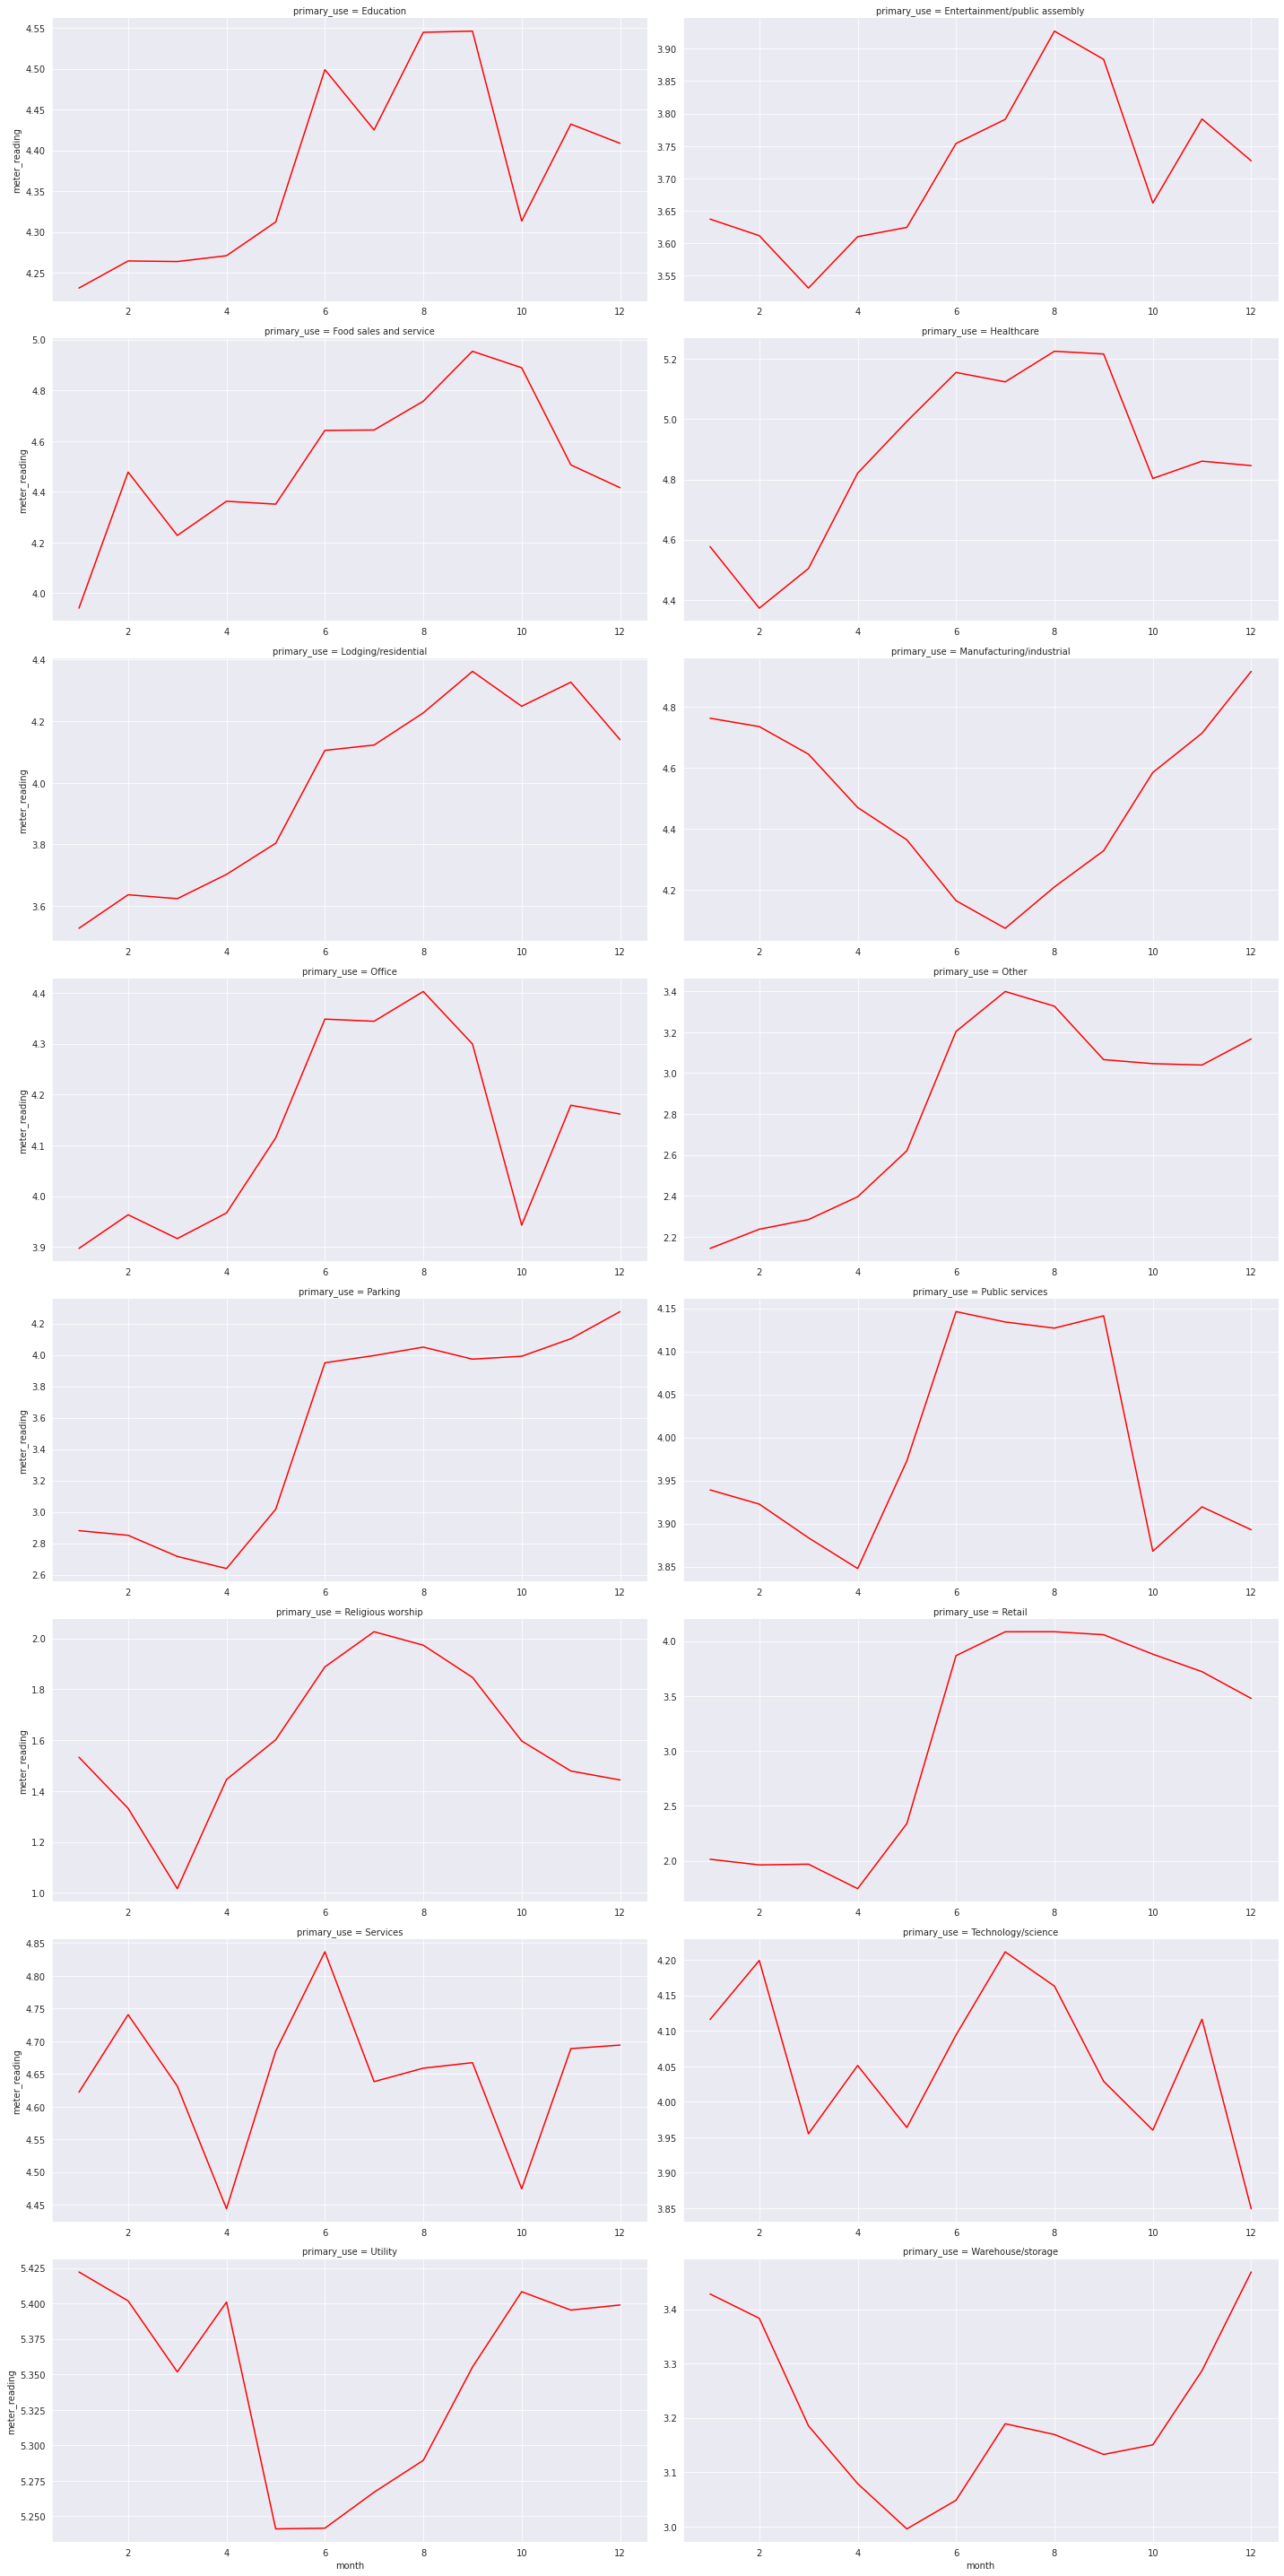

In [ ]:
#Monthy average readings based on type of buildings
month_use_df= train_df.groupby(['month', 'primary_use']).meter_reading.mean().reset_index()
p=sns.FacetGrid(month_use_df, col='primary_use', col_wrap=2, height=5, aspect=2, sharey=False, sharex=False)
p.map(sns.lineplot, 'month', 'meter_reading', color='red')
plt.show()

In the above figure, we have plotted the average hourly usage for each of the primary usage category.



*   The educational institutes have the peak usage in August and September. The usage is minimum in the initial months of the year.
*   The consumption for enetertainment as well as food sales buildings rises is minimum  around March and maximum in August.
*  There is a clear decreasing trend for manufacturing which hits the minimum in the july month and then starts rising again.


### 3.11 Distribution Plot: Air Temperature

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


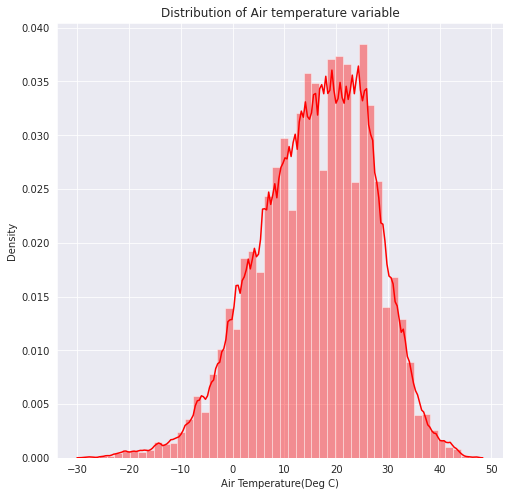

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['air_temperature'].dropna(), color='red')
plt.xlabel("Air Temperature(Deg C)")
plt.title("Distribution of Air temperature variable")
plt.show()

The air temperature roughly follows a normal distribution. The maximum observations lie between 0-30 deg C.

### 3.12 Mean meter readings by air temperature

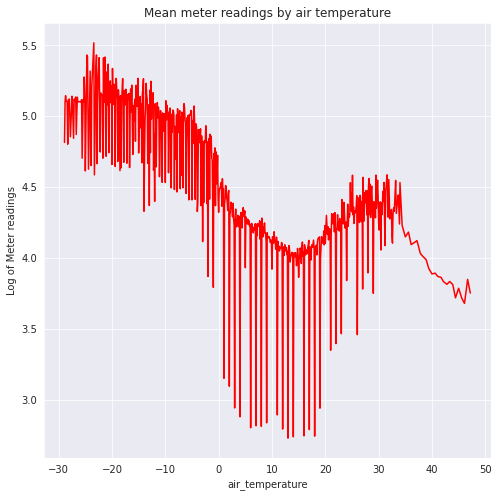

In [ ]:
plt.figure(figsize=(8,8))
temp_df= train_df.groupby('air_temperature').meter_reading.mean().reset_index()
sns.lineplot(x=temp_df['air_temperature'], y=temp_df['meter_reading'], color='red')
plt.ylabel("Log of Meter readings")
plt.title("Mean meter readings by air temperature")
plt.show()

The average meter readings are high when the temperature is negative, once it starts increasing, the meter consumption reduces. It again increases when the temperature rises above 15 deg C.

### 3.13 Mean temperatures by site ds

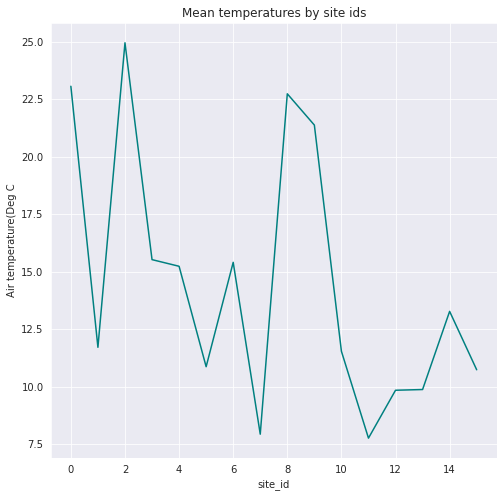

In [ ]:
plt.figure(figsize=(8,8))
floor_df= train_df.groupby('site_id').air_temperature.mean().reset_index()
sns.lineplot(x=floor_df['site_id'], y=floor_df['air_temperature'], color='teal')
plt.ylabel("Air temperature(Deg C")
plt.title("Mean temperatures by site ids")
plt.show()

There is  huge variation in temperatures of various sites. It seems that some sights lie in the northern parts and some in southern parts.

### 3.14 Distribution Plot: Dew temperature

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


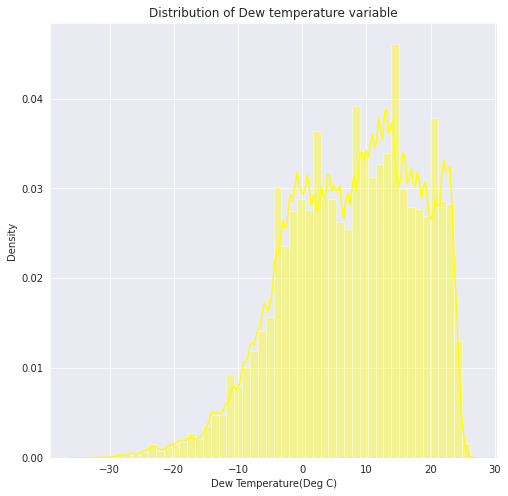

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['dew_temperature'].dropna(), color='yellow')
plt.xlabel("Dew Temperature(Deg C)")
plt.title("Distribution of Dew temperature variable")
plt.show()

The dew temperature is bit skewed towards right. The maximum observations lie between 0-20 deg C

### 3.15 Distribution plot: Cloud Coverage

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


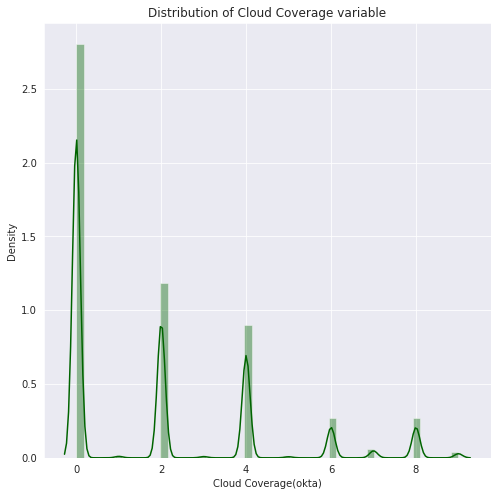

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['cloud_coverage'], color='darkgreen')
plt.xlabel("Cloud Coverage(okta)")
plt.title("Distribution of Cloud Coverage variable")
plt.show()

Majority of the observations have cloud coverage as 0. There are lot of missing values in cloud coverage. We will impute them later.

### 3.18 Distribution Plot: precip_depth_1_hr

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


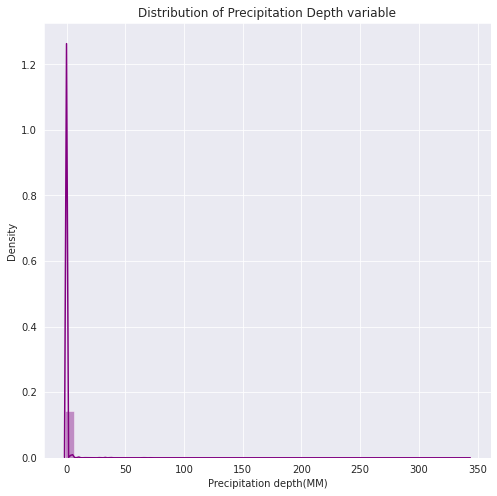

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['precip_depth_1_hr'], color='purple')
plt.xlabel("Precipitation depth(MM)")
plt.title("Distribution of Precipitation Depth variable")
plt.show()

The data is heavily skewed with maximum observations recording zero. Also there are lot of missing values in this variable.

### 3.19 Distribution plot: Sea level pressure

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


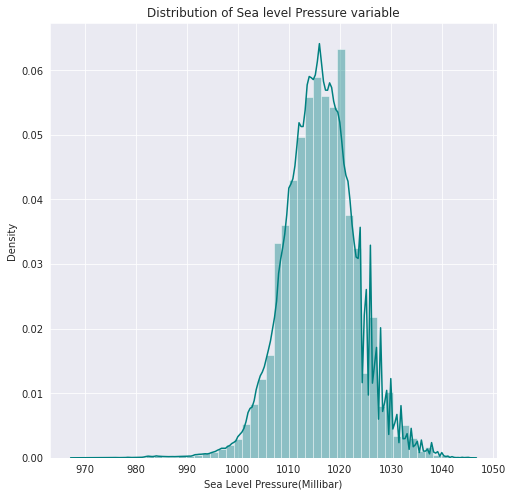

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['sea_level_pressure'], color='teal')
plt.xlabel("Sea Level Pressure(Millibar)")
plt.title("Distribution of Sea level Pressure variable")
plt.show()

This follows a normal distribution with maximum of the observations lying between 1000 to 1030 millibar.

### 3.20 Distribution plot: floor count

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


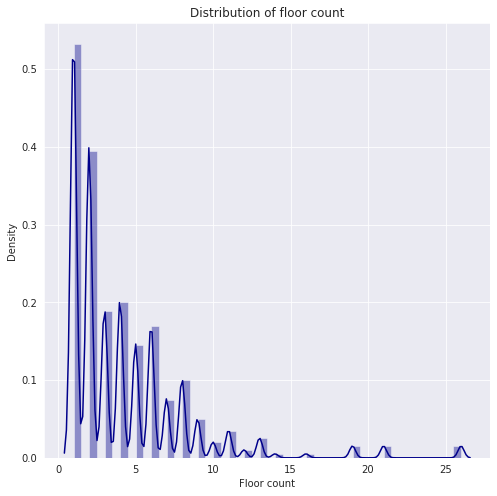

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['floor_count'].dropna(), color='darkblue')
plt.xlabel("Floor count")
plt.title("Distribution of floor count")
plt.show()

Not much of the buildings have floors greater than 10. The maximum buildings have floors less than 5.

### 3.21 Mean meter readings by floor count

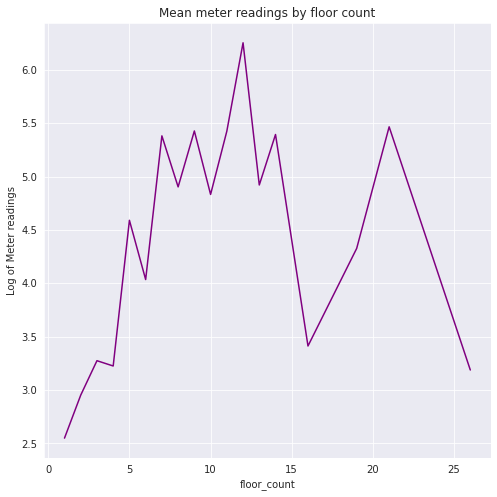

In [ ]:
plt.figure(figsize=(8,8))
floor_df= train_df.groupby('floor_count').meter_reading.mean().reset_index()
sns.lineplot(x=floor_df['floor_count'], y=floor_df['meter_reading'], color='purple')
plt.ylabel("Log of Meter readings")
plt.title("Mean meter readings by floor count")
plt.show()

When the floor count is more than 10 the meter reading peaks and then drops. This might be due to several reasons like not all the floors are used at a time.

### 3.22 Distribution plot: Year built

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


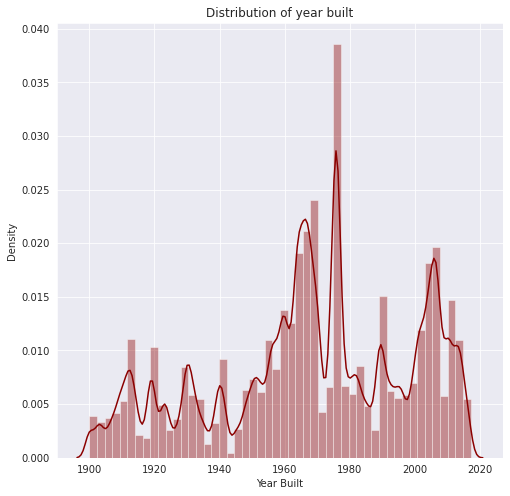

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['year_built'].dropna(), color='darkred')
plt.xlabel("Year Built")
plt.title("Distribution of year built")
plt.show()

The distribution is spread over a period of 120 years. Most of the buildings are built after 1960.

### 3.23 Mean meter readings by year built

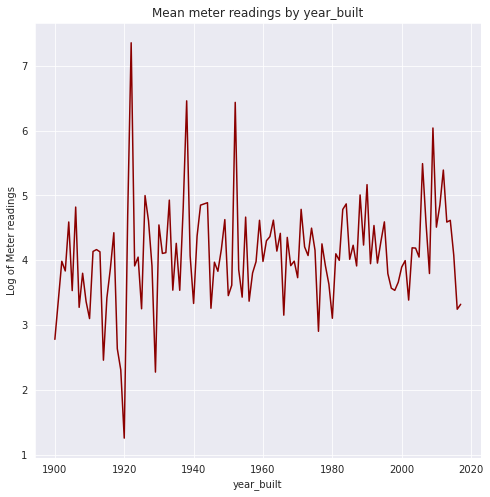

In [ ]:
plt.figure(figsize=(8,8))
year_df= train_df.groupby('year_built').meter_reading.mean().reset_index()
sns.lineplot(x=year_df['year_built'], y=year_df['meter_reading'], color='darkred')
plt.ylabel("Log of Meter readings")
plt.title("Mean meter readings by year_built")
plt.show()

The average consumption is higher for buildings built before 1940.

### 3.24 Distribution plot: square feet

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


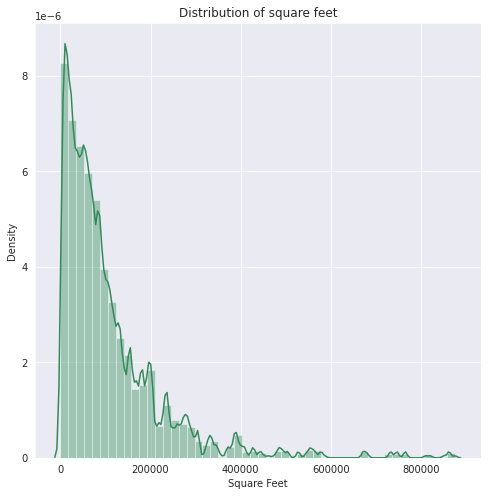

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['square_feet'], color='seagreen')
plt.xlabel("Square Feet")
plt.title("Distribution of square feet")
plt.show()

As the square feet is also heavily skewed and the scale of values is also very large hence we will apply a log transformation here and plot the distribution.

In [ ]:
train_df['square_feet']=np.log1p(train_df['square_feet'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


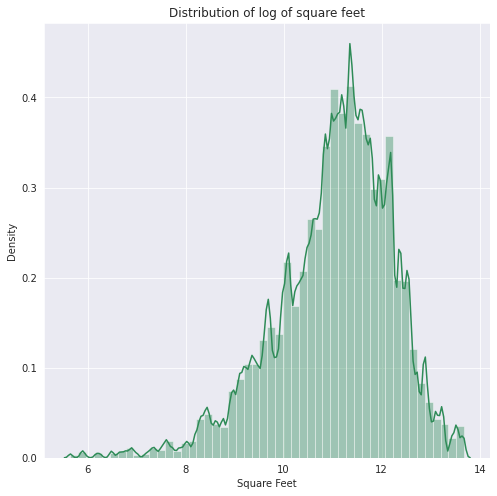

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['square_feet'], color='seagreen')
plt.xlabel("Square Feet")
plt.title("Distribution of log of square feet")
plt.show()

Now the distribution looks better after log transformations. We will plot the mean energy consumption plot with the square feet and observe the trend.

### 3.25 Mean meter readings by square feet

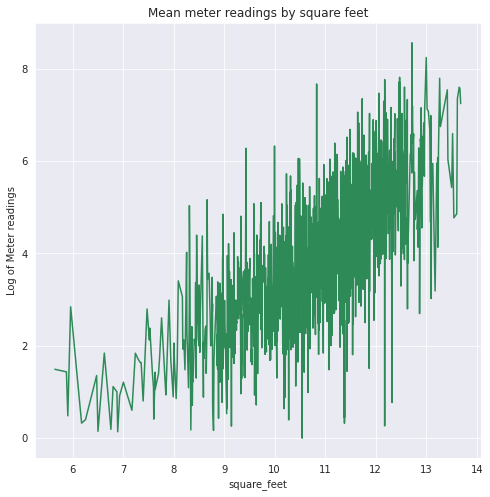

In [ ]:
plt.figure(figsize=(8,8))
feet_df= train_df.groupby('square_feet').meter_reading.mean().reset_index()
sns.lineplot(x=feet_df['square_feet'], y=feet_df['meter_reading'], color='seagreen')
plt.ylabel("Log of Meter readings")
plt.title("Mean meter readings by square feet")
plt.show()

There is clear positive relation between the two. As the size of the building increases, the meter consumption also increases.

### 3.26 Sitewise Average Consumption

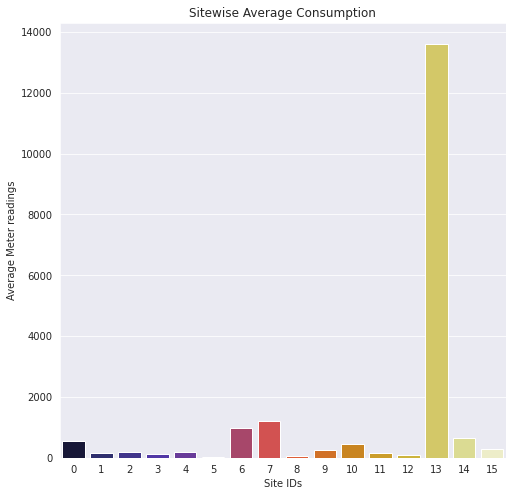

In [ ]:
#Sitewide consumption
plt.figure(figsize=(8,8))
site_df= train_df.groupby(['site_id']).meter_reading.mean().reset_index()
sns.barplot(x=site_df['site_id'], y=site_df['meter_reading'], palette='CMRmap')
plt.ylabel("Average Meter readings")
plt.xlabel("Site IDs")
plt.title("Sitewise Average Consumption")
plt.show()

Site13 records the highest average consumption followed by site7, site6. The minimum consumption is recorded by site5.

### 3.27 Sitewise Hourly Average Consumption

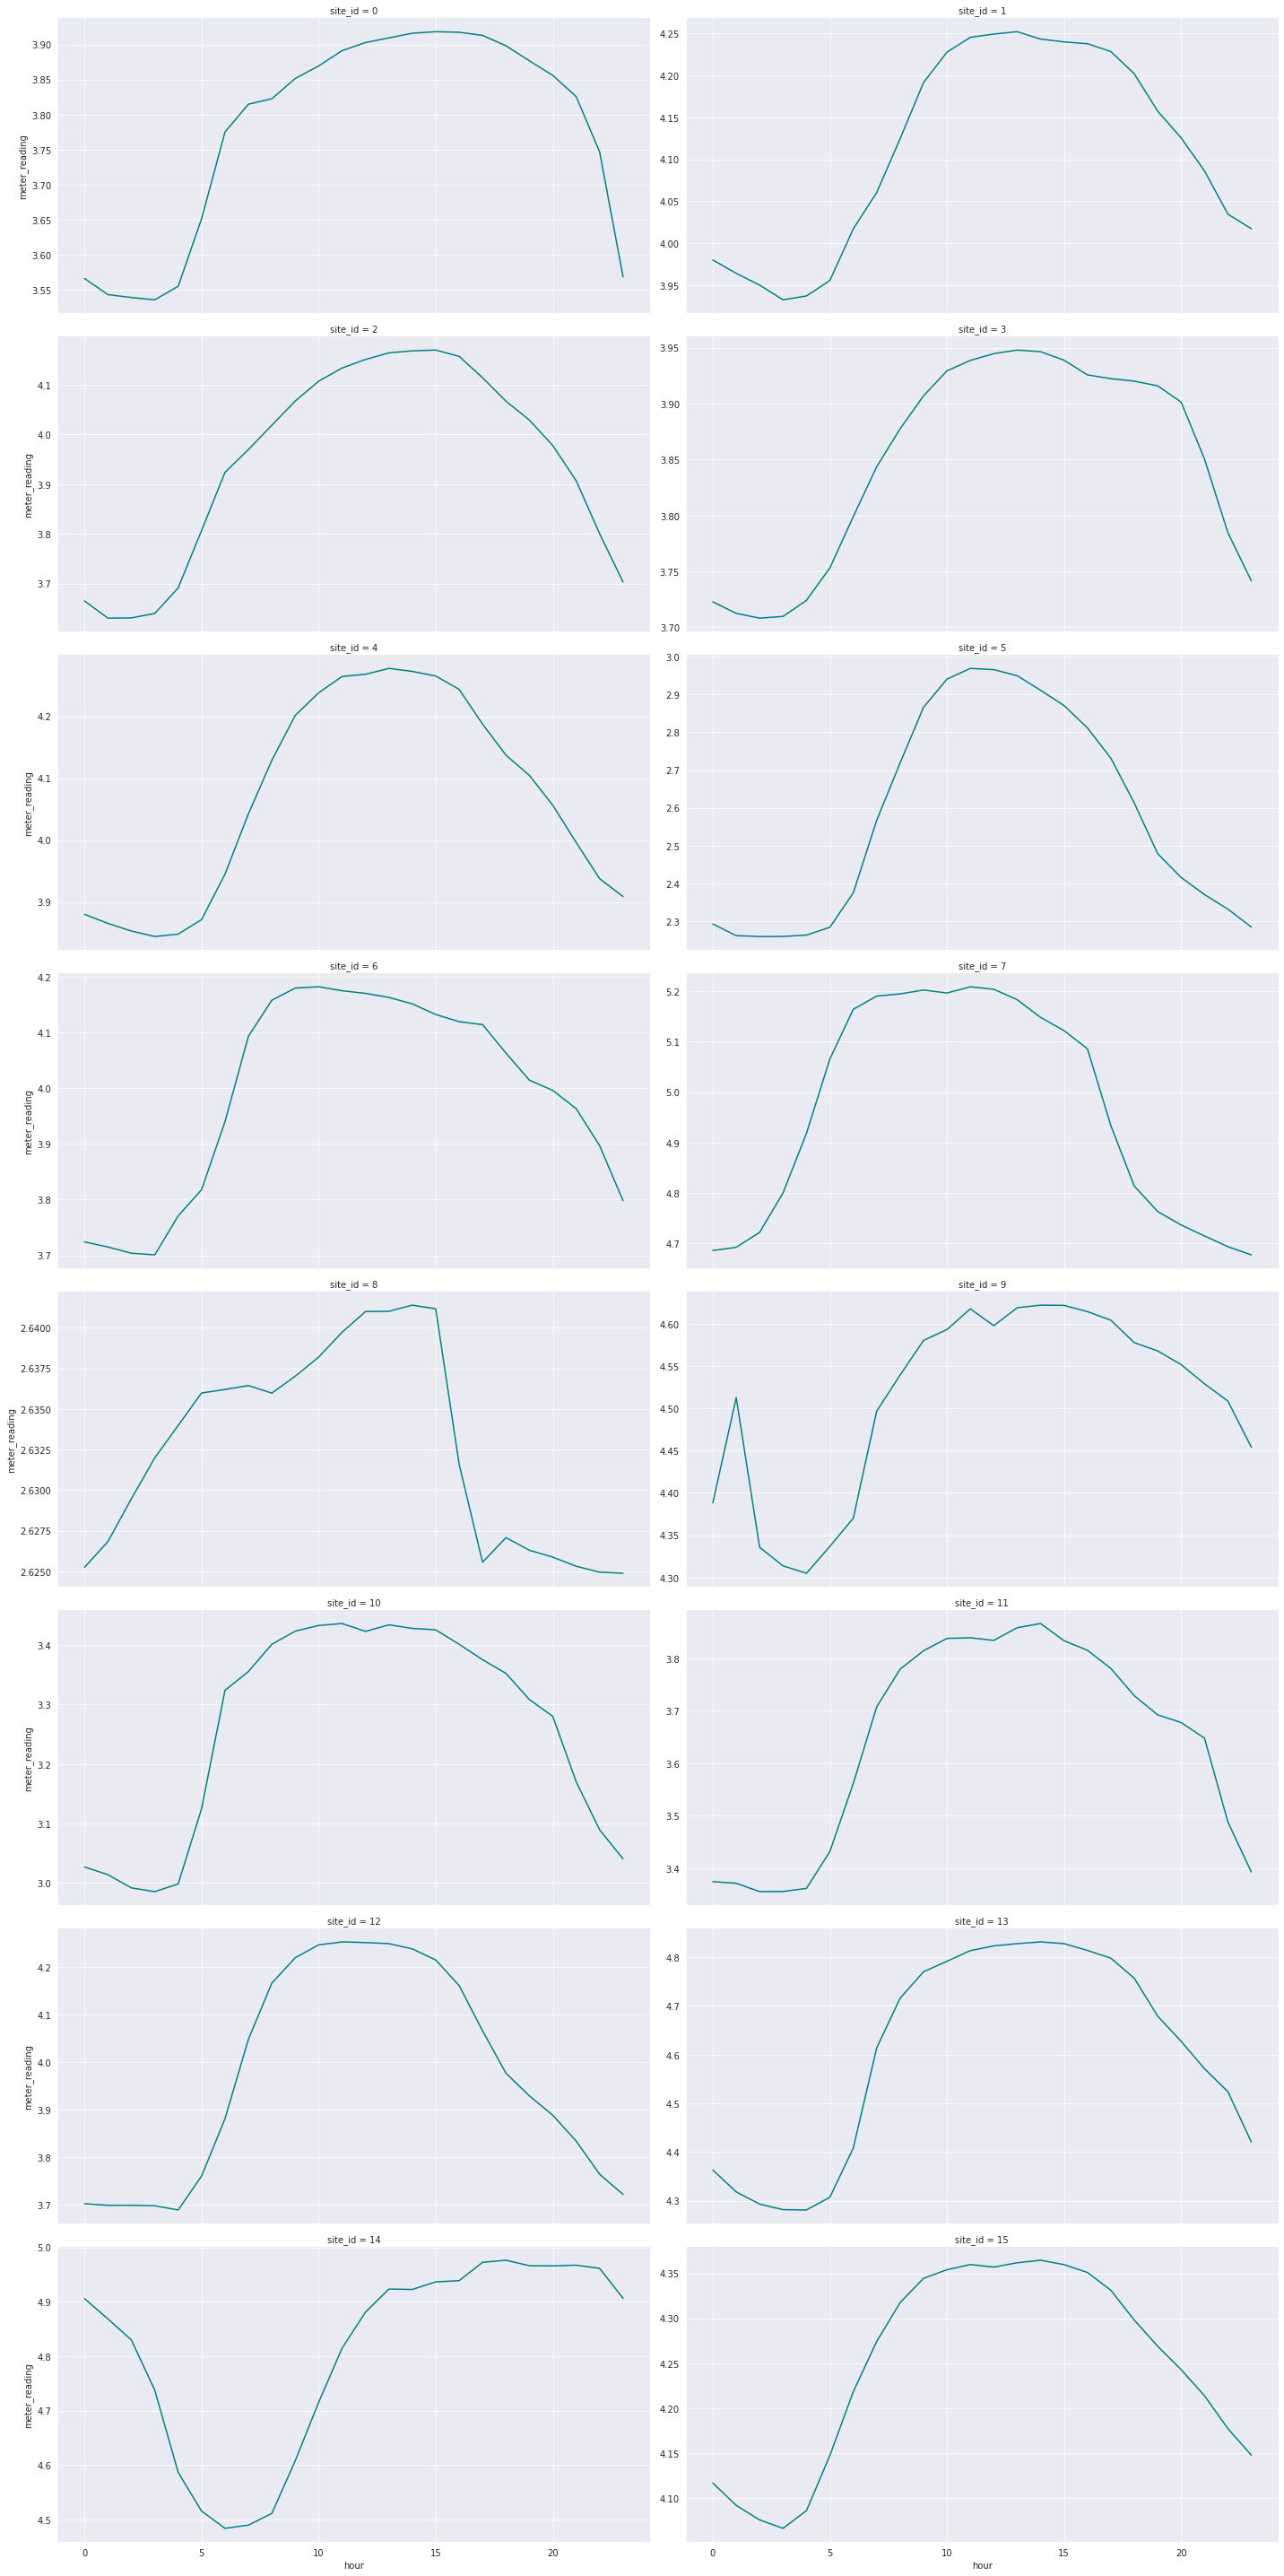

In [ ]:
hour_use_df= train_df.groupby(['site_id', 'hour']).meter_reading.mean().reset_index()
p=sns.FacetGrid(hour_use_df, col='site_id', col_wrap=2, height=5, aspect=2, sharey=False)
p.map(sns.lineplot, 'hour', 'meter_reading', color='teal')
plt.show()

As we can see in the above plots, all the sites follow a similar usage patterns on hourly basis. The consumption drops to a minimum in the early hours of the day and then rises after 6am. It hits the peak in the afternoon and then drops after 7pm.

### 3.28 Buildingwise Average meter readings

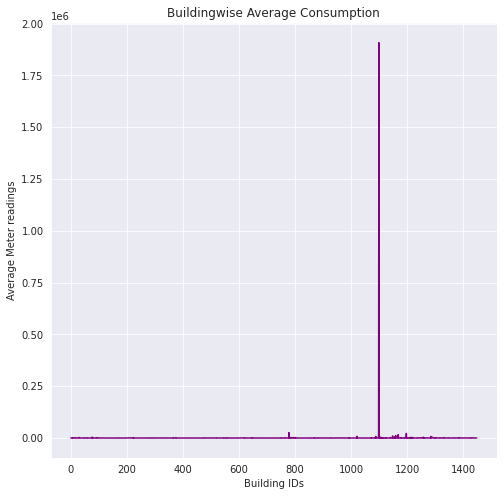

In [ ]:
plt.figure(figsize=(8,8))
site_df= train_df.groupby(['building_id']).meter_reading.mean().reset_index()
sns.lineplot(x=site_df['building_id'], y=site_df['meter_reading'], color='purple')
plt.ylabel("Average Meter readings")
plt.xlabel("Building IDs")
plt.title("Buildingwise Average Consumption")
plt.show()

In [ ]:
print(train_df[train_df.meter_reading == train_df.meter_reading.max()])

         building_id  meter           timestamp  ...  dayofyear  day  year
8907488         1099      2 2016-06-13 09:00:00  ...        165   13  2016

[1 rows x 22 columns]


In [ ]:
train_df.iloc[8907488]

building_id                          1099
meter                                   2
timestamp             2016-06-13 09:00:00
meter_reading                 2.19047e+07
site_id                                13
primary_use                     Education
square_feet                        332884
year_built                            NaN
floor_count                           NaN
air_temperature                   19.4062
cloud_coverage                        NaN
dew_temperature                   17.2031
precip_depth_1_hr                       0
sea_level_pressure                 1014.5
wind_direction                         50
wind_speed                        6.19922
hour                                    9
dayofweek                               0
month                                   6
dayofyear                             165
day                                    13
year                                 2016
Name: 8907488, dtype: object

As we can see from the above plot, the meter readings vary accross the buildings. Building 1099 have a huge spike in their usage while many buildings use very less energy. It will be considered as an outlier. We will also check the building having second highest meter reading after removing the building 1099 readings


### 3.29 Correlation Matrix

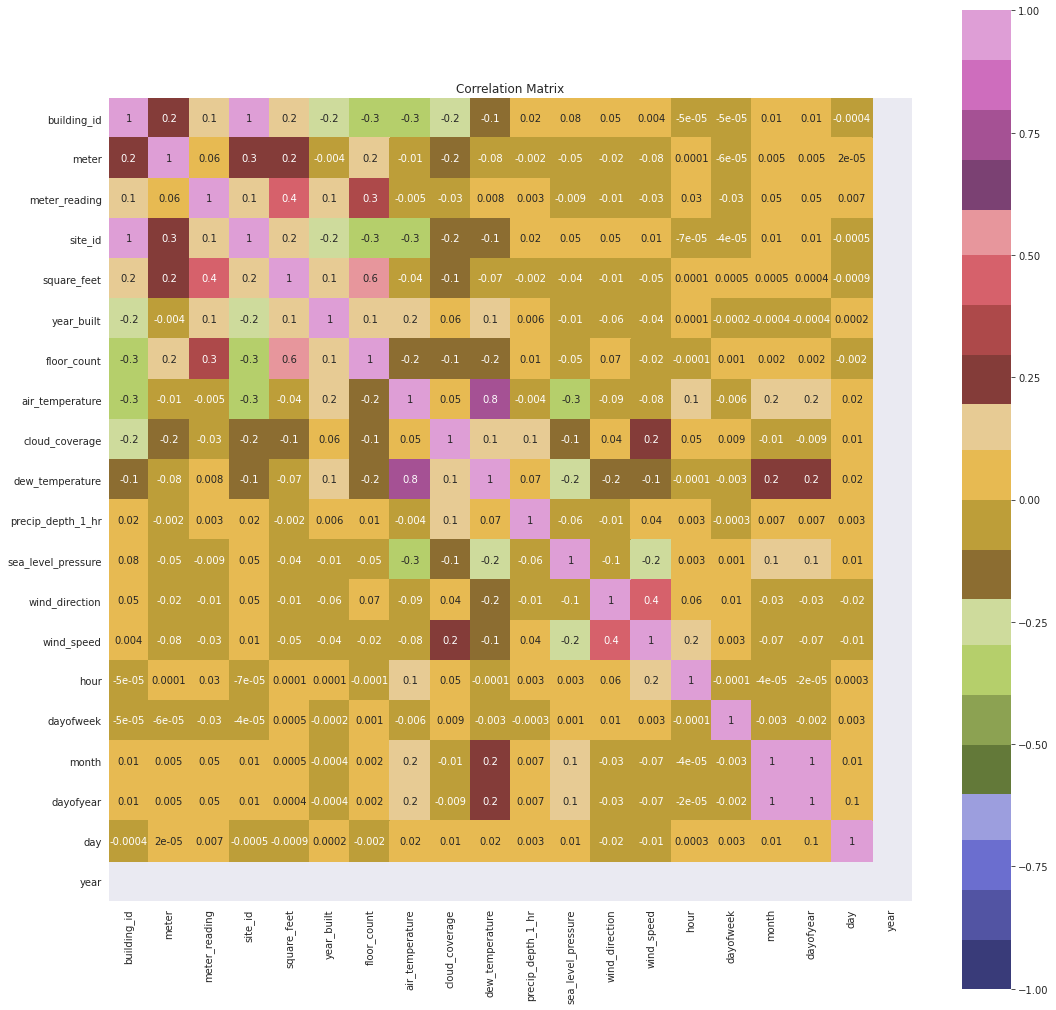

In [ ]:
#Correlation Matrix
plt.figure(figsize=(18,18))
sns.heatmap(train_df.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, square=True, cmap='tab20b')
plt.title('Correlation Matrix')

We have plotted the correlation matrix of the features available. The square feet and floor count features have a strong positive correlation with the target variable. As we know size of the building is a huge factor on how much energy its is consuming. Year built is also having a slight positive correlation as older buildings tend to consume more energy than the newer ones.

In [ ]:
!pip install windrose

### 3.30 Windrose Plot for wind direction and speed.

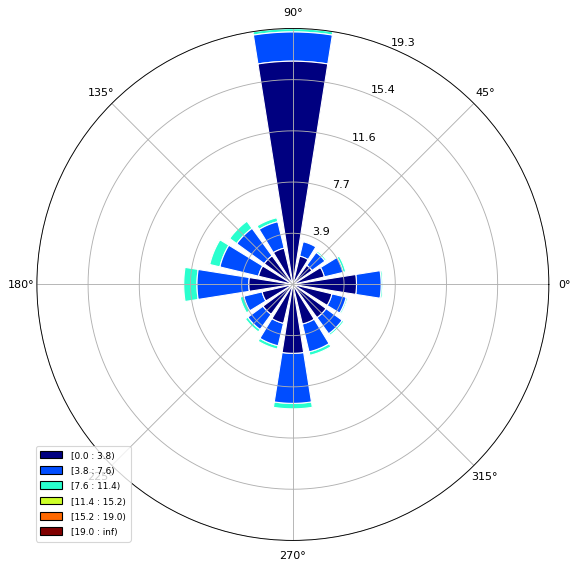

In [ ]:
from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(train_df['wind_direction'], train_df['wind_speed'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

The above windrose diagram shows that for most of the sites, the wind blows from north direction(90 degrees) most of the time, followed by south direction(270 degrees). It also shows that wind blows the least from NE direction(45 degrees). When the wind blows from the north, maximum of the times the speed is between 0 to 3.8 m/s.

## 4. Feature Engineering

### 4.1 Outlier Treatment

We have seen from our previous observation that building 1099 is an outlier. Lets first see the statistics for that building.

In [ ]:
train_df[train_df['building_id']==1099]['meter_reading'].describe()

count    1.756600e+04
mean     1.907326e+06
std      4.834750e+06
min      1.440000e+02
25%      5.203910e+02
50%      9.856970e+02
75%      7.008000e+03
max      2.190470e+07
Name: meter_reading, dtype: float64

In [ ]:
#removing the observations for building 1099
drop_indices= list(train_df[train_df['building_id']==1099].index)
train_df.drop(drop_indices, axis=0, inplace=True)

In [ ]:
print(train_df.meter_reading.max())

13.688103675842285


In [ ]:
train_df[train_df['building_id']==778]['meter_reading'].describe()

count    16860.000000
mean         3.487550
std          3.450661
min          0.000000
25%          0.000000
50%          5.066700
75%          5.585844
max         13.688104
Name: meter_reading, dtype: float64

Building 778 is also having enormously high reading which is dominating the readings after removing building 1099.

In [ ]:
#removing the observations for building 1099
drop_indices= list(train_df[train_df['building_id']==778].index)
train_df.drop(drop_indices, axis=0, inplace=True)

As we know there are significantly higher number of zero readings in the dataset which does not make sense in the real world. These might be due to the case that either they are erroneous or actual readings are not available for those timestamps. Hence we will remove the zero reading observations.

In [ ]:
#removing the observations with 0 meter_readings
drop_0readings= list(train_df[train_df['meter_reading']==0.0].index)
train_df.drop(drop_0readings, axis=0, inplace=True)

### 4.2 Missing Value Imputation

In [ ]:
#Check percentage of missing values in each column
def percent_missing_val(df):

  percent_missing = (df.isnull().sum() * 100) / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df

In [ ]:
missing_value_train= percent_missing_val(train_df)

In [ ]:
missing_value_test= percent_missing_val(test_df)

In [ ]:
missing_value_train

,column_name,percent_missing
building_id,building_id,0.000000
meter,meter,0.000000
timestamp,timestamp,0.000000
meter_reading,meter_reading,0.000000
site_id,site_id,0.000000
primary_use,primary_use,0.000000
square_feet,square_feet,0.000000
year_built,year_built,59.955237
floor_count,floor_count,82.637685
air_temperature,air_temperature,0.478520


In [ ]:
missing_value_test

,column_name,percent_missing
row_id,row_id,0.000000
building_id,building_id,0.000000
meter,meter,0.000000
timestamp,timestamp,0.000000
site_id,site_id,0.000000
primary_use,primary_use,0.000000
square_feet,square_feet,0.000000
year_built,year_built,58.991597
floor_count,floor_count,82.605042
air_temperature,air_temperature,0.532167


As the year built and floor count columns have more than 50% values are missing, so we will drop these two columns.

In [ ]:
train_df.drop(['year_built', 'floor_count'], axis=1,inplace=True)


In [ ]:
test_df.drop(['year_built', 'floor_count'], axis=1,inplace=True)

In [ ]:
def nan_fillers(df):
  air_temp_df=df.groupby(['site_id', 'day', 'month'])['air_temperature'].transform('mean')
  df['air_temperature'].fillna(air_temp_df, inplace=True)

  dew_temp_df=df.groupby(['site_id', 'day', 'month'])['dew_temperature'].transform('mean')
  df['dew_temperature'].fillna(dew_temp_df, inplace=True)

  cloud_df=df.groupby(['site_id', 'day', 'month'])['cloud_coverage'].transform('mean')
  df['cloud_coverage'].fillna(cloud_df, inplace=True)

  sea_level_df=df.groupby(['site_id', 'day', 'month'])['sea_level_pressure'].transform('mean')
  df['sea_level_pressure'].fillna(sea_level_df, inplace=True)

  precip_df=df.groupby(['site_id', 'day', 'month'])['precip_depth_1_hr'].transform('mean')
  df['precip_depth_1_hr'].fillna(precip_df, inplace=True)

  wind_dir_df=df.groupby(['site_id', 'day', 'month'])['wind_direction'].transform('mean')
  df['wind_direction'].fillna(wind_dir_df, inplace=True)

  wind_speed_df=df.groupby(['site_id', 'day', 'month'])['wind_speed'].transform('mean')
  df['wind_speed'].fillna(wind_speed_df, inplace=True)


  return df

In [ ]:
train_df= nan_fillers(train_df)

In [ ]:
train_df.isnull().sum()

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
air_temperature             0
cloud_coverage        1222254
dew_temperature             0
precip_depth_1_hr     2676779
sea_level_pressure     822312
wind_direction              0
wind_speed                  0
hour                        0
dayofweek                   0
month                       0
dayofyear                   0
day                         0
year                        0
dtype: int64

In [ ]:
train_df['cloud_coverage'].fillna(train_df['cloud_coverage'].median(), inplace=True)
train_df['sea_level_pressure'].fillna(train_df['sea_level_pressure'].median(), inplace=True)
train_df['precip_depth_1_hr'].fillna(train_df['precip_depth_1_hr'].median(), inplace=True)

As there were lot of slices where all the values were NAN in 3 columns namely: cloud_coverage, precip_depth_1_hr and sea_level_pressure hence we will impute the rest of the nan values with the median value.

Now we will preprocess the test data

In [ ]:
test_df=nan_fillers(test_df)

In [ ]:
test_df.isnull().sum()

row_id                      0
building_id                 0
meter                       0
timestamp                   0
site_id                     0
primary_use                 0
square_feet                 0
air_temperature             0
cloud_coverage        1429680
dew_temperature             0
precip_depth_1_hr     4197504
sea_level_pressure    1559280
wind_direction              0
wind_speed                  0
hour                        0
dayofweek                   0
month                       0
dayofyear                   0
day                         0
year                        0
dtype: int64

In [ ]:
test_df['cloud_coverage'].fillna(test_df['cloud_coverage'].median(), inplace=True)
test_df['sea_level_pressure'].fillna(test_df['sea_level_pressure'].median(), inplace=True)
test_df['precip_depth_1_hr'].fillna(test_df['precip_depth_1_hr'].median(), inplace=True)

### 4.3 Adding new features

In [ ]:
#Adding holiday features
import holidays

location_df= pd.DataFrame()
location_df['site_id']= np.arange(0,16)
location_df['city']= ['Orlando', 'Heathrow', 'Tempe', 'Washington', 'Berkeley', 'Southampton', 'Washington', 'Ottowa', 'Orlando', 'Austin', 'Saltlake',\
                  'Ottowa', 'Dublin', 'Minneapolis', 'Philadelphia', 'Rochestor']

location_df['country']= ['US', 'UK', 'US', 'US', 'US', 'UK', 'US', 'Canada', 'US', 'US', 'US', 'Canada', 'Ireland', 'US', 'US', 'US']
    

In [ ]:
train_df=train_df.merge(location_df, on='site_id', how='left')

In [ ]:
test_df=test_df.merge(location_df, on='site_id', how='left')

In [ ]:
#geeksforgeeks.org/python-holidays-library/
UK=[]
US=[]
CA=[]
IRE=[]

for ptr in holidays.UnitedKingdom(years = 2016).keys():
    UK.append(str(ptr))
for ptr in holidays.UnitedKingdom(years = 2017).keys():
    UK.append(str(ptr))
for ptr in holidays.UnitedKingdom(years = 2018).keys():
    UK.append(str(ptr))
UK.append('2019-01-01')


for ptr in holidays.UnitedStates(years = 2016).keys():
    US.append(str(ptr))
for ptr in holidays.UnitedStates(years = 2017).keys():
    US.append(str(ptr))
for ptr in holidays.UnitedStates(years = 2018).keys():
    US.append(str(ptr))
US.append('2019-01-01')


for ptr in holidays.Canada(years = 2016).keys():
    CA.append(str(ptr))
for ptr in holidays.Canada(years = 2017).keys():
    CA.append(str(ptr))
for ptr in holidays.Canada(years = 2018).keys():
    CA.append(str(ptr))
CA.append('2019-01-01')


for ptr in holidays.Ireland(years = 2016).keys():
    IRE.append(str(ptr))
for ptr in holidays.Ireland(years = 2017).keys():
    IRE.append(str(ptr))
for ptr in holidays.Ireland(years = 2018).keys():
    IRE.append(str(ptr))
IRE.append('2019-01-01')

In [ ]:
def holiday_filler(df):
  df['isHoliday']=[0]*(df.shape[0])
  df.loc[df['country']=='US', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(US)).astype('int')
  df.loc[df['country']=='UK', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(UK)).astype('int')
  df.loc[df['country']=='Canada', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(CA)).astype('int')
  df.loc[df['country']=='Ireland', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(IRE)).astype('int')

  return df

In [ ]:
train_df= holiday_filler(train_df)

In [ ]:
test_df= holiday_filler(test_df)

In [ ]:
#adding season features
train_df['season']= train_df['timestamp'].apply(lambda x: 'Spring' if x.month==3 or x.month==4 or x.month==5 else 'Summer' if 
                                                x.month==6 or x.month==7 or x.month==8 
                                                else 'Autumn' if x.month==9 or x.month==10 or 
                                                x.month==11 else 'Winter')

In [ ]:
#Adding day and night period features
train_df['IsDayTime']= train_df['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=18 else 0)

In [ ]:
#Adding relative humidity
train_df['relative_humidity']= 100*((np.exp((17.67*train_df['dew_temperature'])/
                                            (243.5+train_df['dew_temperature'])))/(np.exp((17.67*train_df['air_temperature'])/
                                                                                          (243.5+train_df['air_temperature']))))

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,...,month,dayofyear,day,year,city,country,isHoliday,season,IsDayTime,relative_humidity
0,46,0,2016-01-01,3.993413,0,Retail,9.110078,25.000000,6.0,20.000000,...,1,1,1,2016,Orlando,US,1,Winter,0,73.8125
1,74,0,2016-01-01,3.784219,0,Parking,12.867830,25.000000,6.0,20.000000,...,1,1,1,2016,Orlando,US,1,Winter,0,73.8125
2,93,0,2016-01-01,3.978196,0,Office,10.415443,25.000000,6.0,20.000000,...,1,1,1,2016,Orlando,US,1,Winter,0,73.8125
3,105,0,2016-01-01,3.190624,1,Education,10.832181,3.800781,0.0,2.400391,...,1,1,1,2016,Heathrow,UK,1,Winter,0,90.5000
4,106,0,2016-01-01,0.318163,1,Education,8.589514,3.800781,0.0,2.400391,...,1,1,1,2016,Heathrow,UK,1,Winter,0,90.5000


In [ ]:
#adding features in test data
test_df['season']= test_df['timestamp'].apply(lambda x: 'Spring' if x.month==3 or x.month==4 or x.month==5 else 'Summer' if x.month==6 or x.month==7 or x.month==8 
                                                else 'Autumn' if x.month==9 or x.month==10 or 
                                                x.month==11 else 'Winter')
test_df['IsDayTime']= test_df['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=18 else 0)
test_df['relative_humidity']= 100*((np.exp((17.67*test_df['dew_temperature'])/(243.5+test_df['dew_temperature'])))/(np.exp((17.67*test_df['air_temperature'])/(243.5+test_df['air_temperature']))))


In [ ]:
#Dropping unnecessary columns
train_df.drop(['city','country'], axis=1, inplace=True)

In [ ]:
test_df['square_feet']=np.log1p(test_df['square_feet'])
test_df.drop(['city','country'], axis=1, inplace=True)

### 4.3 Baseline Model

For baseline model, we will use the site_id and primary use to find the mean readings.

In [ ]:
#baseline model
y_pred_df= train_df.groupby(['site_id', 'primary_use'])['meter_reading'].mean().reset_index()


In [ ]:
y_pred_df

,site_id,primary_use,meter_reading
0,0,Education,6.384432
1,0,Entertainment/public assembly,5.621823
2,0,Lodging/residential,5.867753
3,0,Office,5.371202
4,0,Other,4.612487
...,...,...,...
105,15,Office,4.089089
106,15,Public services,4.914351
107,15,Religious worship,2.004147
108,15,Technology/science,5.011249


### Train-CV split(time based)

In [ ]:
train_df=train_df.sort_values(by='timestamp')

In [ ]:
X_train, X_cv= train_test_split(train_df, test_size=0.20, shuffle=False)

In [ ]:
#y_pred for baseline
y_pred_df.rename(columns={"meter_reading": "y_pred_base"}, inplace=True)
X_train= X_train.merge(y_pred_df, on=['site_id', 'primary_use'], how='left')
X_cv= X_cv.merge(y_pred_df,on=['site_id', 'primary_use'], how='left')

In [ ]:
#rsmle score for baseline model
rmse_base_tr=math.sqrt(mean_squared_error(X_train['meter_reading'], X_train['y_pred_base']))
rmse_base_cv=math.sqrt(mean_squared_error(X_cv['meter_reading'], X_cv['y_pred_base']))
print("RMSE for baseline model for train data:", rmse_base_tr)
print("RMSE for baseline model for cv data:", rmse_base_cv)

RMSE for baseline model for train data: 1.5006950675370332
RMSE for baseline model for cv data: 1.5341502380458434


In [ ]:
#Label encoding primary use variables
from sklearn.preprocessing import LabelEncoder

label_enc= LabelEncoder()


In [ ]:
label_enc.fit(train_df['primary_use'])
X_train['primary_use']= label_enc.transform(X_train['primary_use'])
X_cv['primary_use']= label_enc.transform(X_cv['primary_use'])

In [ ]:
test_df['primary_use']= label_enc.transform(test_df['primary_use'])

In [ ]:
label_enc.fit(train_df['season'])
X_train['season']= label_enc.transform(X_train['season'])
X_cv['season']= label_enc.transform(X_cv['season'])

In [ ]:
test_df['season']= label_enc.transform(test_df['season'])

In [ ]:
y_readings_tr=X_train['meter_reading']
y_readings_cv=X_cv['meter_reading']
X_train.drop(['meter_reading', 'y_pred_base'], axis=1, inplace=True)
X_cv.drop(['meter_reading', 'y_pred_base'], axis=1, inplace=True)

## VIF for multicollinearity

In [ ]:
#https://etav.github.io/python/vif_factor_python.html
#http://statisticshowto.com/variance-inflation-factor/

from statsmodels.stats.outliers_influence import variance_inflation_factor
s=X_train._get_numeric_data()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(s.values, i) for i in range(s.shape[1])]
vif["features"] = s.columns

In [ ]:
vif

,VIF Factor,features
0,31.595354,building_id
1,1.184713,meter
2,30.937562,site_id
3,1.081822,primary_use
4,1.119603,square_feet
5,24.142073,air_temperature
6,1.232325,cloud_coverage
7,22.801793,dew_temperature
8,1.029883,precip_depth_1_hr
9,1.322246,sea_level_pressure


site_id and building_id is highly correlated so we will drop one of them. Also, among air_tempearature and dew_temperature we will keep one of them. We will drop year and dayofyear column as well

In [ ]:
X_train.drop(['site_id', 'dew_temperature','timestamp','year','dayofyear'],axis=1,inplace=True)
X_cv.drop(['site_id', 'dew_temperature','timestamp','year','dayofyear'],axis=1,inplace=True)

In [ ]:
test_df.drop(['site_id', 'dew_temperature','timestamp','year','dayofyear'],axis=1,inplace=True)

In [ ]:
#Saving final data in files
test_df.to_feather('/content/drive/MyDrive/Appliedai files/Case study 1/Data/test_df.ftr')

In [ ]:
#Converting pandas series to numpy
y_readings_tr=y_readings_tr.to_numpy()
y_readings_cv=y_readings_cv.to_numpy()

In [ ]:
X_train.to_feather('X_train_new.ftr')
X_cv.to_feather('X_cv_new.ftr')
np.save('y_readings_tr_new.npy', y_readings_tr)
np.save('y_readings_cv_new.npy',y_readings_cv)

## Model Train and Hyperparameter tuning

In [ ]:
X_train= pd.read_feather('/content/drive/MyDrive/Appliedai files/Case study 1/Data/X_train_new.ftr')
X_cv= pd.read_feather('/content/drive/MyDrive/Appliedai files/Case study 1/Data/X_cv_new.ftr')

In [ ]:
y_readings_tr= np.load('/content/drive/MyDrive/Appliedai files/Case study 1/Data/y_readings_tr_new.npy')
y_readings_cv= np.load('/content/drive/MyDrive/Appliedai files/Case study 1/Data/y_readings_cv_new.npy')

In [ ]:
X_train=reduce_mem_usage(X_train)
X_cv=reduce_mem_usage(X_cv)

Memory usage of dataframe is 866.34 MB
Memory usage after optimization is: 433.17 MB
Decreased by 50.0%
Memory usage of dataframe is 216.58 MB
Memory usage after optimization is: 108.29 MB
Decreased by 50.0%


In [ ]:
X_train.shape

(14651953, 18)

### Decision Tree Regressor

In [ ]:
cv_error_array=[]
depth=[3,5,7,9,11,15]
for i in depth:
  d_reg=DecisionTreeRegressor(max_depth=i)
  d_reg.fit(X_train,y_readings_tr)
  pred_d_reg=d_reg.predict(X_cv)
  cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_d_reg)))
  print("rmse for max_depth:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_d_reg)))

rmse for max_depth: 3 is 1.4220906965975486
rmse for max_depth: 5 is 1.2912788604683232
rmse for max_depth: 7 is 1.1558882727579691
rmse for max_depth: 9 is 1.046170956463021
rmse for max_depth: 11 is 0.9414936410923004
rmse for max_depth: 15 is 0.8293354900043265


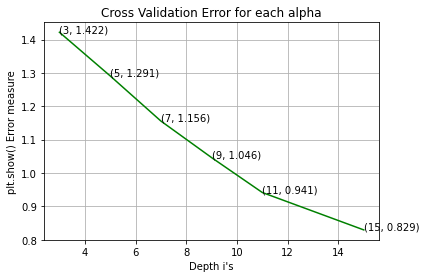

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(depth, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((depth[i],np.round(txt,3)), (depth[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Depth i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
d_reg=DecisionTreeRegressor(max_depth=depth[best_alpha],random_state=5)
d_reg.fit(X_train,y_readings_tr)
pred_d_reg_tr=d_reg.predict(X_train)
pred_d_reg_cv=d_reg.predict(X_cv)
print("Train rmse for max_depth:", depth[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_tr, pred_d_reg_tr)))
print("CV rmse for max_depth:", depth[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_cv, pred_d_reg_cv)))

Train rmse for max_depth: 15 is 0.6062994813016952
CV rmse for max_depth: 15 is 0.8234762515599422


In [ ]:
#Save the models to a pickle file for making predictions on test data in future
filename_reg='decision_tree_reg.sav'
joblib.dump(d_reg,filename_reg)

['decision_tree_reg.sav']

### LGBM Regressor

In [ ]:
import lightgbm as lgb
lgb_estimators=[75,150,500,1000,2000]
cv_error_array=[]
for i in lgb_estimators:
    lgb_reg=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=i,objective='rmse', n_jobs=-1)
    lgb_reg.fit(X_train,y_readings_tr)
    pred_reg_lgb=lgb_reg.predict(X_cv)
    cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb)))

rmse for estimators: 75 is 0.9192466577617009
rmse for estimators: 150 is 0.8503978893079152
rmse for estimators: 500 is 0.7163582237738891
rmse for estimators: 1000 is 0.6662325900773165
rmse for estimators: 2000 is 0.6322274216369068


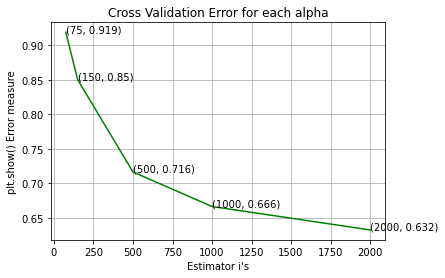

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(lgb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((lgb_estimators[i],np.round(txt,3)), (lgb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
lgb_reg=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=lgb_estimators[best_alpha], objective='rmse',n_jobs=-1)
lgb_reg.fit(X_train,y_readings_tr)
pred_reg_lgb_cv=lgb_reg.predict(X_cv)
pred_reg_lgb_tr=lgb_reg.predict(X_train)
print("Train rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_tr, pred_reg_lgb_tr)))
print("CV rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb_cv)))

Train rmse for estimators: 2000 is 0.4530165299046579
CV rmse for estimators: 2000 is 0.6322471324725991


In [ ]:
filename_reg='lgb_reg.sav'
joblib.dump(lgb_reg,filename_reg)

['lgb_reg.sav']

### LGBM Random Forest Regressor

In [ ]:
cv_error_array=[]
for i in lgb_estimators:
    rf_reg=lgb.LGBMRegressor(boosting_type='rf', n_estimators=i, n_jobs=-1,objective='rmse',subsample=0.8,feature_fraction=0.8,bagging_freq=1)
    rf_reg.fit(X_train,y_readings_tr)
    pred_rf_reg=rf_reg.predict(X_cv)
    cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_rf_reg)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_rf_reg)))

rmse for estimators: 75 is 1.2231724059780795
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
rmse for estimators: 150 is 1.220441798951858
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
rmse for estimators: 500 is 1.2181123911342384
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
rmse for estimators: 1000 is 1.217556735284479
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fractio

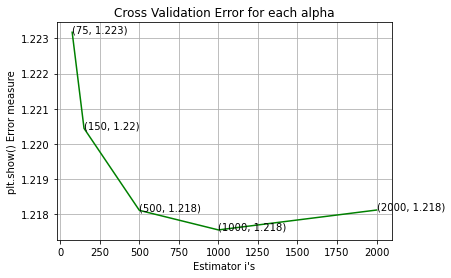

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(lgb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((lgb_estimators[i],np.round(txt,3)), (lgb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
rf_reg=lgb.LGBMRegressor(boosting_type='rf', n_estimators=lgb_estimators[best_alpha], n_jobs=-1,objective='rmse',subsample=0.8,feature_fraction=0.8,bagging_freq=1)
rf_reg.fit(X_train,y_readings_tr)
pred_reg_lgb_cv=rf_reg.predict(X_cv)
pred_reg_lgb_tr=rf_reg.predict(X_train)
print("Train rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_tr, pred_reg_lgb_tr)))
print("CV rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb_cv)))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Train rmse for estimators: 1000 is 1.192729593822491
CV rmse for estimators: 1000 is 1.217556735284479


In [ ]:
#Save the models to a pickle file for making predictions on test data in future
filename_reg='rf_reg.sav'
joblib.dump(rf_reg,filename_reg)

['rf_reg.sav']

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.3 MB 68 kB/s  eta 0:00:01
     |████████████████████████████████| 13.2 MB 91.5 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=1d7ec0c03d993f6137990de2ac3a03518e5249bb146cea9169df49c735a23468
  Stored in directory: /home/azureuser/.cache/pip/wheels/ac/cb/8a/b27bf6323e2f4c462dcbf77d70b7c5e7868a7fbe12871770cf
Successfully built retrying


### CatBoost Regressor

In [ ]:
import catboost as cb
cb_estimators=[75,150,500,1000,1500]
cv_error_array=[]
for i in cb_estimators:
    cb_reg=cb.CatBoostRegressor(n_estimators=i)
    cb_reg.fit(X_train,y_readings_tr)
    pred_reg_cb=cb_reg.predict(X_cv)
    cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_reg_cb)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_cb)))

Learning rate set to 0.5
0:	learn: 1.4466246	total: 1.07s	remaining: 1m 19s
1:	learn: 1.3374488	total: 2s	remaining: 1m 13s
2:	learn: 1.2627657	total: 2.95s	remaining: 1m 10s
3:	learn: 1.2078358	total: 3.88s	remaining: 1m 8s
4:	learn: 1.1843435	total: 4.75s	remaining: 1m 6s
5:	learn: 1.1405750	total: 5.67s	remaining: 1m 5s
6:	learn: 1.1274023	total: 6.62s	remaining: 1m 4s
7:	learn: 1.1126525	total: 7.55s	remaining: 1m 3s
8:	learn: 1.0885941	total: 8.51s	remaining: 1m 2s
9:	learn: 1.0742149	total: 9.37s	remaining: 1m
10:	learn: 1.0616569	total: 10.3s	remaining: 59.7s
11:	learn: 1.0462763	total: 11.2s	remaining: 58.8s
12:	learn: 1.0397962	total: 12.1s	remaining: 57.9s
13:	learn: 1.0324705	total: 13s	remaining: 56.6s
14:	learn: 1.0247540	total: 14s	remaining: 56s
15:	learn: 1.0179950	total: 15s	remaining: 55.3s
16:	learn: 1.0074892	total: 15.9s	remaining: 54.3s
17:	learn: 0.9994999	total: 16.9s	remaining: 53.5s
18:	learn: 0.9952065	total: 17.8s	remaining: 52.3s
19:	learn: 0.9908540	total:

84:	learn: 0.8098069	total: 1m 18s	remaining: 1m
85:	learn: 0.8069660	total: 1m 19s	remaining: 59.2s
86:	learn: 0.8048175	total: 1m 20s	remaining: 58.3s
87:	learn: 0.8026116	total: 1m 21s	remaining: 57.5s
88:	learn: 0.8016304	total: 1m 22s	remaining: 56.6s
89:	learn: 0.8001706	total: 1m 23s	remaining: 55.6s
90:	learn: 0.7988491	total: 1m 24s	remaining: 54.7s
91:	learn: 0.7977223	total: 1m 25s	remaining: 53.7s
92:	learn: 0.7960340	total: 1m 26s	remaining: 52.8s
93:	learn: 0.7947613	total: 1m 26s	remaining: 51.8s
94:	learn: 0.7928987	total: 1m 27s	remaining: 50.9s
95:	learn: 0.7918165	total: 1m 28s	remaining: 49.9s
96:	learn: 0.7902719	total: 1m 29s	remaining: 48.9s
97:	learn: 0.7885385	total: 1m 30s	remaining: 48s
98:	learn: 0.7867286	total: 1m 31s	remaining: 47.1s
99:	learn: 0.7858357	total: 1m 32s	remaining: 46.2s
100:	learn: 0.7839884	total: 1m 33s	remaining: 45.3s
101:	learn: 0.7819767	total: 1m 34s	remaining: 44.4s
102:	learn: 0.7806935	total: 1m 35s	remaining: 43.5s
103:	learn: 0.

91:	learn: 0.8381886	total: 1m 23s	remaining: 6m 10s
92:	learn: 0.8369364	total: 1m 24s	remaining: 6m 9s
93:	learn: 0.8360410	total: 1m 25s	remaining: 6m 8s
94:	learn: 0.8332726	total: 1m 26s	remaining: 6m 8s
95:	learn: 0.8316766	total: 1m 27s	remaining: 6m 7s
96:	learn: 0.8302736	total: 1m 28s	remaining: 6m 6s
97:	learn: 0.8293001	total: 1m 29s	remaining: 6m 5s
98:	learn: 0.8276222	total: 1m 30s	remaining: 6m 4s
99:	learn: 0.8261467	total: 1m 30s	remaining: 6m 3s
100:	learn: 0.8247007	total: 1m 31s	remaining: 6m 2s
101:	learn: 0.8235211	total: 1m 32s	remaining: 6m 1s
102:	learn: 0.8216817	total: 1m 33s	remaining: 6m 1s
103:	learn: 0.8206103	total: 1m 34s	remaining: 6m
104:	learn: 0.8196145	total: 1m 35s	remaining: 5m 59s
105:	learn: 0.8187752	total: 1m 36s	remaining: 5m 58s
106:	learn: 0.8181200	total: 1m 37s	remaining: 5m 57s
107:	learn: 0.8172563	total: 1m 38s	remaining: 5m 57s
108:	learn: 0.8164076	total: 1m 39s	remaining: 5m 56s
109:	learn: 0.8149769	total: 1m 40s	remaining: 5m 55

245:	learn: 0.6911328	total: 3m 46s	remaining: 3m 53s
246:	learn: 0.6908070	total: 3m 46s	remaining: 3m 52s
247:	learn: 0.6901107	total: 3m 47s	remaining: 3m 51s
248:	learn: 0.6894051	total: 3m 48s	remaining: 3m 50s
249:	learn: 0.6887795	total: 3m 49s	remaining: 3m 49s
250:	learn: 0.6877632	total: 3m 50s	remaining: 3m 48s
251:	learn: 0.6869914	total: 3m 51s	remaining: 3m 47s
252:	learn: 0.6863215	total: 3m 52s	remaining: 3m 46s
253:	learn: 0.6860226	total: 3m 53s	remaining: 3m 45s
254:	learn: 0.6853990	total: 3m 54s	remaining: 3m 45s
255:	learn: 0.6850120	total: 3m 55s	remaining: 3m 44s
256:	learn: 0.6843084	total: 3m 56s	remaining: 3m 43s
257:	learn: 0.6839865	total: 3m 57s	remaining: 3m 42s
258:	learn: 0.6833560	total: 3m 57s	remaining: 3m 41s
259:	learn: 0.6823617	total: 3m 59s	remaining: 3m 40s
260:	learn: 0.6820951	total: 3m 59s	remaining: 3m 39s
261:	learn: 0.6815146	total: 4m	remaining: 3m 38s
262:	learn: 0.6806501	total: 4m 1s	remaining: 3m 37s
263:	learn: 0.6801420	total: 4m 2

398:	learn: 0.6230030	total: 6m 7s	remaining: 1m 32s
399:	learn: 0.6226875	total: 6m 7s	remaining: 1m 31s
400:	learn: 0.6224320	total: 6m 8s	remaining: 1m 31s
401:	learn: 0.6219644	total: 6m 9s	remaining: 1m 30s
402:	learn: 0.6216763	total: 6m 10s	remaining: 1m 29s
403:	learn: 0.6214682	total: 6m 11s	remaining: 1m 28s
404:	learn: 0.6208313	total: 6m 12s	remaining: 1m 27s
405:	learn: 0.6206822	total: 6m 13s	remaining: 1m 26s
406:	learn: 0.6204472	total: 6m 14s	remaining: 1m 25s
407:	learn: 0.6200928	total: 6m 14s	remaining: 1m 24s
408:	learn: 0.6196919	total: 6m 15s	remaining: 1m 23s
409:	learn: 0.6194723	total: 6m 16s	remaining: 1m 22s
410:	learn: 0.6191374	total: 6m 17s	remaining: 1m 21s
411:	learn: 0.6186978	total: 6m 18s	remaining: 1m 20s
412:	learn: 0.6179919	total: 6m 19s	remaining: 1m 19s
413:	learn: 0.6177993	total: 6m 20s	remaining: 1m 19s
414:	learn: 0.6175053	total: 6m 21s	remaining: 1m 18s
415:	learn: 0.6171627	total: 6m 22s	remaining: 1m 17s
416:	learn: 0.6169190	total: 6m 

52:	learn: 0.9677464	total: 46.6s	remaining: 13m 52s
53:	learn: 0.9655242	total: 47.4s	remaining: 13m 50s
54:	learn: 0.9633999	total: 48.4s	remaining: 13m 51s
55:	learn: 0.9618993	total: 49.3s	remaining: 13m 50s
56:	learn: 0.9600140	total: 50.2s	remaining: 13m 49s
57:	learn: 0.9593887	total: 51s	remaining: 13m 48s
58:	learn: 0.9579928	total: 51.9s	remaining: 13m 48s
59:	learn: 0.9557982	total: 52.9s	remaining: 13m 48s
60:	learn: 0.9533493	total: 53.8s	remaining: 13m 48s
61:	learn: 0.9518387	total: 54.8s	remaining: 13m 48s
62:	learn: 0.9508457	total: 55.7s	remaining: 13m 47s
63:	learn: 0.9493010	total: 56.5s	remaining: 13m 46s
64:	learn: 0.9469399	total: 57.5s	remaining: 13m 47s
65:	learn: 0.9451367	total: 58.4s	remaining: 13m 46s
66:	learn: 0.9426806	total: 59.4s	remaining: 13m 46s
67:	learn: 0.9413486	total: 1m	remaining: 13m 45s
68:	learn: 0.9399435	total: 1m 1s	remaining: 13m 45s
69:	learn: 0.9380801	total: 1m 2s	remaining: 13m 45s
70:	learn: 0.9367116	total: 1m 3s	remaining: 13m 44

204:	learn: 0.7955676	total: 3m 4s	remaining: 11m 53s
205:	learn: 0.7946892	total: 3m 5s	remaining: 11m 53s
206:	learn: 0.7938046	total: 3m 6s	remaining: 11m 53s
207:	learn: 0.7928130	total: 3m 7s	remaining: 11m 52s
208:	learn: 0.7916032	total: 3m 8s	remaining: 11m 51s
209:	learn: 0.7910604	total: 3m 8s	remaining: 11m 50s
210:	learn: 0.7905792	total: 3m 9s	remaining: 11m 49s
211:	learn: 0.7895210	total: 3m 10s	remaining: 11m 48s
212:	learn: 0.7891134	total: 3m 11s	remaining: 11m 47s
213:	learn: 0.7882828	total: 3m 12s	remaining: 11m 46s
214:	learn: 0.7878904	total: 3m 13s	remaining: 11m 45s
215:	learn: 0.7872586	total: 3m 14s	remaining: 11m 44s
216:	learn: 0.7860508	total: 3m 15s	remaining: 11m 43s
217:	learn: 0.7849639	total: 3m 16s	remaining: 11m 43s
218:	learn: 0.7842573	total: 3m 16s	remaining: 11m 42s
219:	learn: 0.7832161	total: 3m 17s	remaining: 11m 41s
220:	learn: 0.7826013	total: 3m 18s	remaining: 11m 40s
221:	learn: 0.7820388	total: 3m 19s	remaining: 11m 40s
222:	learn: 0.781

355:	learn: 0.7122389	total: 5m 25s	remaining: 9m 48s
356:	learn: 0.7117465	total: 5m 26s	remaining: 9m 48s
357:	learn: 0.7114047	total: 5m 27s	remaining: 9m 47s
358:	learn: 0.7108045	total: 5m 28s	remaining: 9m 46s
359:	learn: 0.7105214	total: 5m 29s	remaining: 9m 45s
360:	learn: 0.7100732	total: 5m 30s	remaining: 9m 44s
361:	learn: 0.7096875	total: 5m 31s	remaining: 9m 44s
362:	learn: 0.7089127	total: 5m 32s	remaining: 9m 43s
363:	learn: 0.7081035	total: 5m 33s	remaining: 9m 42s
364:	learn: 0.7077310	total: 5m 34s	remaining: 9m 41s
365:	learn: 0.7073881	total: 5m 35s	remaining: 9m 40s
366:	learn: 0.7069366	total: 5m 36s	remaining: 9m 40s
367:	learn: 0.7067424	total: 5m 37s	remaining: 9m 39s
368:	learn: 0.7063336	total: 5m 38s	remaining: 9m 38s
369:	learn: 0.7060019	total: 5m 39s	remaining: 9m 37s
370:	learn: 0.7056753	total: 5m 40s	remaining: 9m 36s
371:	learn: 0.7053851	total: 5m 40s	remaining: 9m 35s
372:	learn: 0.7051357	total: 5m 42s	remaining: 9m 34s
373:	learn: 0.7047172	total:

508:	learn: 0.6610996	total: 7m 45s	remaining: 7m 29s
509:	learn: 0.6607022	total: 7m 46s	remaining: 7m 28s
510:	learn: 0.6604893	total: 7m 47s	remaining: 7m 27s
511:	learn: 0.6603063	total: 7m 48s	remaining: 7m 26s
512:	learn: 0.6600448	total: 7m 49s	remaining: 7m 25s
513:	learn: 0.6599024	total: 7m 50s	remaining: 7m 24s
514:	learn: 0.6596788	total: 7m 50s	remaining: 7m 23s
515:	learn: 0.6593055	total: 7m 51s	remaining: 7m 22s
516:	learn: 0.6588897	total: 7m 52s	remaining: 7m 21s
517:	learn: 0.6588243	total: 7m 53s	remaining: 7m 20s
518:	learn: 0.6587279	total: 7m 54s	remaining: 7m 19s
519:	learn: 0.6579456	total: 7m 55s	remaining: 7m 18s
520:	learn: 0.6577861	total: 7m 56s	remaining: 7m 17s
521:	learn: 0.6575013	total: 7m 57s	remaining: 7m 16s
522:	learn: 0.6573687	total: 7m 58s	remaining: 7m 16s
523:	learn: 0.6572012	total: 7m 58s	remaining: 7m 15s
524:	learn: 0.6569746	total: 7m 59s	remaining: 7m 14s
525:	learn: 0.6566320	total: 8m	remaining: 7m 13s
526:	learn: 0.6564803	total: 8m 

661:	learn: 0.6263617	total: 10m 8s	remaining: 5m 10s
662:	learn: 0.6262377	total: 10m 9s	remaining: 5m 9s
663:	learn: 0.6259526	total: 10m 10s	remaining: 5m 8s
664:	learn: 0.6256516	total: 10m 11s	remaining: 5m 7s
665:	learn: 0.6255982	total: 10m 11s	remaining: 5m 6s
666:	learn: 0.6254474	total: 10m 12s	remaining: 5m 5s
667:	learn: 0.6252875	total: 10m 13s	remaining: 5m 5s
668:	learn: 0.6250571	total: 10m 14s	remaining: 5m 4s
669:	learn: 0.6248755	total: 10m 15s	remaining: 5m 3s
670:	learn: 0.6247296	total: 10m 16s	remaining: 5m 2s
671:	learn: 0.6245194	total: 10m 17s	remaining: 5m 1s
672:	learn: 0.6243467	total: 10m 18s	remaining: 5m
673:	learn: 0.6242139	total: 10m 18s	remaining: 4m 59s
674:	learn: 0.6240799	total: 10m 19s	remaining: 4m 58s
675:	learn: 0.6237619	total: 10m 20s	remaining: 4m 57s
676:	learn: 0.6236390	total: 10m 21s	remaining: 4m 56s
677:	learn: 0.6232912	total: 10m 22s	remaining: 4m 55s
678:	learn: 0.6231117	total: 10m 23s	remaining: 4m 54s
679:	learn: 0.6229992	tota

812:	learn: 0.5997910	total: 12m 27s	remaining: 2m 51s
813:	learn: 0.5996868	total: 12m 27s	remaining: 2m 50s
814:	learn: 0.5994718	total: 12m 28s	remaining: 2m 49s
815:	learn: 0.5992536	total: 12m 29s	remaining: 2m 49s
816:	learn: 0.5991065	total: 12m 30s	remaining: 2m 48s
817:	learn: 0.5988696	total: 12m 31s	remaining: 2m 47s
818:	learn: 0.5987159	total: 12m 32s	remaining: 2m 46s
819:	learn: 0.5985727	total: 12m 33s	remaining: 2m 45s
820:	learn: 0.5985001	total: 12m 34s	remaining: 2m 44s
821:	learn: 0.5983497	total: 12m 35s	remaining: 2m 43s
822:	learn: 0.5979878	total: 12m 36s	remaining: 2m 42s
823:	learn: 0.5978411	total: 12m 37s	remaining: 2m 41s
824:	learn: 0.5976403	total: 12m 38s	remaining: 2m 40s
825:	learn: 0.5975748	total: 12m 39s	remaining: 2m 39s
826:	learn: 0.5974876	total: 12m 40s	remaining: 2m 39s
827:	learn: 0.5972097	total: 12m 41s	remaining: 2m 38s
828:	learn: 0.5970777	total: 12m 42s	remaining: 2m 37s
829:	learn: 0.5969982	total: 12m 42s	remaining: 2m 36s
830:	learn

963:	learn: 0.5802030	total: 14m 44s	remaining: 33s
964:	learn: 0.5800671	total: 14m 45s	remaining: 32.1s
965:	learn: 0.5799542	total: 14m 46s	remaining: 31.2s
966:	learn: 0.5796237	total: 14m 47s	remaining: 30.3s
967:	learn: 0.5793927	total: 14m 48s	remaining: 29.4s
968:	learn: 0.5792849	total: 14m 49s	remaining: 28.5s
969:	learn: 0.5791472	total: 14m 50s	remaining: 27.5s
970:	learn: 0.5790532	total: 14m 51s	remaining: 26.6s
971:	learn: 0.5789570	total: 14m 52s	remaining: 25.7s
972:	learn: 0.5788427	total: 14m 53s	remaining: 24.8s
973:	learn: 0.5787069	total: 14m 54s	remaining: 23.9s
974:	learn: 0.5785385	total: 14m 55s	remaining: 22.9s
975:	learn: 0.5784699	total: 14m 56s	remaining: 22s
976:	learn: 0.5783883	total: 14m 56s	remaining: 21.1s
977:	learn: 0.5782756	total: 14m 57s	remaining: 20.2s
978:	learn: 0.5781545	total: 14m 58s	remaining: 19.3s
979:	learn: 0.5780671	total: 14m 59s	remaining: 18.4s
980:	learn: 0.5780125	total: 15m	remaining: 17.4s
981:	learn: 0.5779844	total: 15m 1s	

116:	learn: 0.9223522	total: 1m 45s	remaining: 20m 42s
117:	learn: 0.9213166	total: 1m 45s	remaining: 20m 41s
118:	learn: 0.9200298	total: 1m 46s	remaining: 20m 39s
119:	learn: 0.9192606	total: 1m 47s	remaining: 20m 38s
120:	learn: 0.9181035	total: 1m 48s	remaining: 20m 38s
121:	learn: 0.9172291	total: 1m 49s	remaining: 20m 37s
122:	learn: 0.9157187	total: 1m 50s	remaining: 20m 36s
123:	learn: 0.9146657	total: 1m 51s	remaining: 20m 35s
124:	learn: 0.9138813	total: 1m 52s	remaining: 20m 34s
125:	learn: 0.9130412	total: 1m 53s	remaining: 20m 32s
126:	learn: 0.9114489	total: 1m 54s	remaining: 20m 32s
127:	learn: 0.9106225	total: 1m 54s	remaining: 20m 31s
128:	learn: 0.9092566	total: 1m 55s	remaining: 20m 31s
129:	learn: 0.9077018	total: 1m 56s	remaining: 20m 31s
130:	learn: 0.9073089	total: 1m 57s	remaining: 20m 31s
131:	learn: 0.9055504	total: 1m 58s	remaining: 20m 30s
132:	learn: 0.9042325	total: 1m 59s	remaining: 20m 29s
133:	learn: 0.9036812	total: 2m	remaining: 20m 28s
134:	learn: 0.

267:	learn: 0.8018378	total: 4m 4s	remaining: 18m 44s
268:	learn: 0.8015054	total: 4m 5s	remaining: 18m 44s
269:	learn: 0.8008700	total: 4m 6s	remaining: 18m 43s
270:	learn: 0.8003376	total: 4m 7s	remaining: 18m 42s
271:	learn: 0.7996951	total: 4m 8s	remaining: 18m 41s
272:	learn: 0.7991683	total: 4m 9s	remaining: 18m 40s
273:	learn: 0.7985416	total: 4m 10s	remaining: 18m 39s
274:	learn: 0.7979460	total: 4m 11s	remaining: 18m 38s
275:	learn: 0.7976530	total: 4m 11s	remaining: 18m 37s
276:	learn: 0.7972093	total: 4m 12s	remaining: 18m 35s
277:	learn: 0.7967294	total: 4m 13s	remaining: 18m 34s
278:	learn: 0.7963535	total: 4m 14s	remaining: 18m 34s
279:	learn: 0.7955774	total: 4m 15s	remaining: 18m 32s
280:	learn: 0.7951898	total: 4m 16s	remaining: 18m 32s
281:	learn: 0.7947785	total: 4m 17s	remaining: 18m 31s
282:	learn: 0.7942918	total: 4m 18s	remaining: 18m 30s
283:	learn: 0.7938176	total: 4m 18s	remaining: 18m 28s
284:	learn: 0.7931286	total: 4m 19s	remaining: 18m 27s
285:	learn: 0.79

418:	learn: 0.7391605	total: 6m 18s	remaining: 16m 17s
419:	learn: 0.7389836	total: 6m 19s	remaining: 16m 15s
420:	learn: 0.7384922	total: 6m 20s	remaining: 16m 15s
421:	learn: 0.7382855	total: 6m 21s	remaining: 16m 14s
422:	learn: 0.7377310	total: 6m 22s	remaining: 16m 13s
423:	learn: 0.7373360	total: 6m 23s	remaining: 16m 12s
424:	learn: 0.7369066	total: 6m 24s	remaining: 16m 11s
425:	learn: 0.7362454	total: 6m 24s	remaining: 16m 10s
426:	learn: 0.7359297	total: 6m 25s	remaining: 16m 9s
427:	learn: 0.7356083	total: 6m 26s	remaining: 16m 8s
428:	learn: 0.7351491	total: 6m 27s	remaining: 16m 7s
429:	learn: 0.7349502	total: 6m 28s	remaining: 16m 6s
430:	learn: 0.7346515	total: 6m 29s	remaining: 16m 6s
431:	learn: 0.7342268	total: 6m 30s	remaining: 16m 4s
432:	learn: 0.7338126	total: 6m 31s	remaining: 16m 4s
433:	learn: 0.7336028	total: 6m 32s	remaining: 16m 2s
434:	learn: 0.7333453	total: 6m 32s	remaining: 16m 1s
435:	learn: 0.7330388	total: 6m 33s	remaining: 16m 1s
436:	learn: 0.732616

569:	learn: 0.6926744	total: 8m 35s	remaining: 14m 1s
570:	learn: 0.6922940	total: 8m 36s	remaining: 14m
571:	learn: 0.6919320	total: 8m 37s	remaining: 13m 59s
572:	learn: 0.6911841	total: 8m 38s	remaining: 13m 59s
573:	learn: 0.6910253	total: 8m 39s	remaining: 13m 58s
574:	learn: 0.6907558	total: 8m 40s	remaining: 13m 57s
575:	learn: 0.6905953	total: 8m 41s	remaining: 13m 57s
576:	learn: 0.6903739	total: 8m 42s	remaining: 13m 56s
577:	learn: 0.6902385	total: 8m 43s	remaining: 13m 55s
578:	learn: 0.6900903	total: 8m 44s	remaining: 13m 54s
579:	learn: 0.6899889	total: 8m 45s	remaining: 13m 53s
580:	learn: 0.6898148	total: 8m 46s	remaining: 13m 52s
581:	learn: 0.6894447	total: 8m 47s	remaining: 13m 51s
582:	learn: 0.6891108	total: 8m 48s	remaining: 13m 50s
583:	learn: 0.6889758	total: 8m 49s	remaining: 13m 49s
584:	learn: 0.6887956	total: 8m 50s	remaining: 13m 49s
585:	learn: 0.6884843	total: 8m 50s	remaining: 13m 48s
586:	learn: 0.6881556	total: 8m 51s	remaining: 13m 47s
587:	learn: 0.6

719:	learn: 0.6589968	total: 10m 54s	remaining: 11m 49s
720:	learn: 0.6587768	total: 10m 55s	remaining: 11m 48s
721:	learn: 0.6586304	total: 10m 56s	remaining: 11m 47s
722:	learn: 0.6585799	total: 10m 57s	remaining: 11m 46s
723:	learn: 0.6583572	total: 10m 58s	remaining: 11m 45s
724:	learn: 0.6581775	total: 10m 59s	remaining: 11m 44s
725:	learn: 0.6578610	total: 11m	remaining: 11m 44s
726:	learn: 0.6576261	total: 11m 1s	remaining: 11m 43s
727:	learn: 0.6573389	total: 11m 2s	remaining: 11m 42s
728:	learn: 0.6571780	total: 11m 3s	remaining: 11m 41s
729:	learn: 0.6571036	total: 11m 4s	remaining: 11m 40s
730:	learn: 0.6570082	total: 11m 5s	remaining: 11m 39s
731:	learn: 0.6567829	total: 11m 5s	remaining: 11m 38s
732:	learn: 0.6566128	total: 11m 6s	remaining: 11m 37s
733:	learn: 0.6565461	total: 11m 7s	remaining: 11m 36s
734:	learn: 0.6563641	total: 11m 8s	remaining: 11m 35s
735:	learn: 0.6561267	total: 11m 9s	remaining: 11m 34s
736:	learn: 0.6559134	total: 11m 10s	remaining: 11m 34s
737:	l

868:	learn: 0.6323040	total: 13m 11s	remaining: 9m 34s
869:	learn: 0.6322040	total: 13m 11s	remaining: 9m 33s
870:	learn: 0.6320097	total: 13m 12s	remaining: 9m 32s
871:	learn: 0.6318468	total: 13m 13s	remaining: 9m 31s
872:	learn: 0.6317125	total: 13m 14s	remaining: 9m 30s
873:	learn: 0.6315929	total: 13m 15s	remaining: 9m 29s
874:	learn: 0.6314632	total: 13m 16s	remaining: 9m 28s
875:	learn: 0.6313677	total: 13m 17s	remaining: 9m 28s
876:	learn: 0.6312861	total: 13m 18s	remaining: 9m 27s
877:	learn: 0.6311162	total: 13m 19s	remaining: 9m 26s
878:	learn: 0.6309309	total: 13m 20s	remaining: 9m 25s
879:	learn: 0.6308072	total: 13m 21s	remaining: 9m 24s
880:	learn: 0.6307213	total: 13m 21s	remaining: 9m 23s
881:	learn: 0.6306026	total: 13m 22s	remaining: 9m 22s
882:	learn: 0.6304995	total: 13m 23s	remaining: 9m 21s
883:	learn: 0.6303213	total: 13m 24s	remaining: 9m 20s
884:	learn: 0.6302441	total: 13m 25s	remaining: 9m 19s
885:	learn: 0.6300826	total: 13m 26s	remaining: 9m 18s
886:	learn

1018:	learn: 0.6134666	total: 15m 26s	remaining: 7m 17s
1019:	learn: 0.6132694	total: 15m 27s	remaining: 7m 16s
1020:	learn: 0.6131530	total: 15m 28s	remaining: 7m 15s
1021:	learn: 0.6130900	total: 15m 28s	remaining: 7m 14s
1022:	learn: 0.6129810	total: 15m 29s	remaining: 7m 13s
1023:	learn: 0.6128353	total: 15m 30s	remaining: 7m 12s
1024:	learn: 0.6127400	total: 15m 31s	remaining: 7m 11s
1025:	learn: 0.6126817	total: 15m 32s	remaining: 7m 10s
1026:	learn: 0.6126036	total: 15m 33s	remaining: 7m 9s
1027:	learn: 0.6122933	total: 15m 34s	remaining: 7m 9s
1028:	learn: 0.6121523	total: 15m 35s	remaining: 7m 8s
1029:	learn: 0.6119674	total: 15m 36s	remaining: 7m 7s
1030:	learn: 0.6118894	total: 15m 37s	remaining: 7m 6s
1031:	learn: 0.6118042	total: 15m 38s	remaining: 7m 5s
1032:	learn: 0.6117442	total: 15m 39s	remaining: 7m 4s
1033:	learn: 0.6116638	total: 15m 39s	remaining: 7m 3s
1034:	learn: 0.6115837	total: 15m 40s	remaining: 7m 2s
1035:	learn: 0.6114711	total: 15m 41s	remaining: 7m 1s
10

1166:	learn: 0.5964791	total: 17m 47s	remaining: 5m 4s
1167:	learn: 0.5963501	total: 17m 48s	remaining: 5m 3s
1168:	learn: 0.5962594	total: 17m 49s	remaining: 5m 2s
1169:	learn: 0.5961086	total: 17m 50s	remaining: 5m 1s
1170:	learn: 0.5959377	total: 17m 51s	remaining: 5m
1171:	learn: 0.5958240	total: 17m 52s	remaining: 5m
1172:	learn: 0.5956308	total: 17m 53s	remaining: 4m 59s
1173:	learn: 0.5955630	total: 17m 54s	remaining: 4m 58s
1174:	learn: 0.5954540	total: 17m 55s	remaining: 4m 57s
1175:	learn: 0.5953673	total: 17m 56s	remaining: 4m 56s
1176:	learn: 0.5952162	total: 17m 57s	remaining: 4m 55s
1177:	learn: 0.5950835	total: 17m 58s	remaining: 4m 54s
1178:	learn: 0.5949417	total: 17m 59s	remaining: 4m 53s
1179:	learn: 0.5948454	total: 18m	remaining: 4m 52s
1180:	learn: 0.5947321	total: 18m 1s	remaining: 4m 51s
1181:	learn: 0.5946194	total: 18m 2s	remaining: 4m 51s
1182:	learn: 0.5945499	total: 18m 2s	remaining: 4m 50s
1183:	learn: 0.5944309	total: 18m 3s	remaining: 4m 49s
1184:	learn:

1314:	learn: 0.5819626	total: 20m 12s	remaining: 2m 50s
1315:	learn: 0.5819305	total: 20m 12s	remaining: 2m 49s
1316:	learn: 0.5818722	total: 20m 13s	remaining: 2m 48s
1317:	learn: 0.5817446	total: 20m 15s	remaining: 2m 47s
1318:	learn: 0.5816520	total: 20m 15s	remaining: 2m 46s
1319:	learn: 0.5815232	total: 20m 17s	remaining: 2m 45s
1320:	learn: 0.5814381	total: 20m 18s	remaining: 2m 45s
1321:	learn: 0.5813383	total: 20m 19s	remaining: 2m 44s
1322:	learn: 0.5812280	total: 20m 20s	remaining: 2m 43s
1323:	learn: 0.5811504	total: 20m 20s	remaining: 2m 42s
1324:	learn: 0.5811117	total: 20m 21s	remaining: 2m 41s
1325:	learn: 0.5810136	total: 20m 22s	remaining: 2m 40s
1326:	learn: 0.5809726	total: 20m 23s	remaining: 2m 39s
1327:	learn: 0.5809229	total: 20m 25s	remaining: 2m 38s
1328:	learn: 0.5808681	total: 20m 25s	remaining: 2m 37s
1329:	learn: 0.5807849	total: 20m 26s	remaining: 2m 36s
1330:	learn: 0.5806871	total: 20m 27s	remaining: 2m 35s
1331:	learn: 0.5805975	total: 20m 28s	remaining:

1462:	learn: 0.5698873	total: 22m 37s	remaining: 34.3s
1463:	learn: 0.5698482	total: 22m 37s	remaining: 33.4s
1464:	learn: 0.5698249	total: 22m 38s	remaining: 32.5s
1465:	learn: 0.5697507	total: 22m 39s	remaining: 31.5s
1466:	learn: 0.5696544	total: 22m 40s	remaining: 30.6s
1467:	learn: 0.5696198	total: 22m 41s	remaining: 29.7s
1468:	learn: 0.5695179	total: 22m 42s	remaining: 28.8s
1469:	learn: 0.5694635	total: 22m 43s	remaining: 27.8s
1470:	learn: 0.5694118	total: 22m 44s	remaining: 26.9s
1471:	learn: 0.5693033	total: 22m 45s	remaining: 26s
1472:	learn: 0.5692700	total: 22m 46s	remaining: 25s
1473:	learn: 0.5691531	total: 22m 47s	remaining: 24.1s
1474:	learn: 0.5691232	total: 22m 48s	remaining: 23.2s
1475:	learn: 0.5690975	total: 22m 49s	remaining: 22.3s
1476:	learn: 0.5689810	total: 22m 50s	remaining: 21.3s
1477:	learn: 0.5689253	total: 22m 51s	remaining: 20.4s
1478:	learn: 0.5688295	total: 22m 52s	remaining: 19.5s
1479:	learn: 0.5687157	total: 22m 53s	remaining: 18.6s
1480:	learn: 0

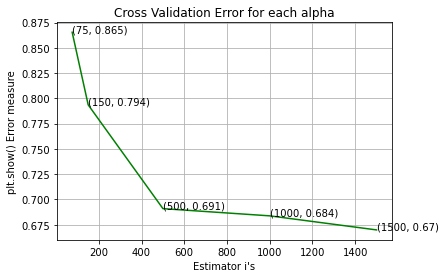

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(cb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((cb_estimators[i],np.round(txt,3)), (cb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
cb_reg=cb.CatBoostRegressor(n_estimators=cb_estimators[best_alpha])
cb_reg.fit(X_train,y_readings_tr)
pred_reg_cb_cv=cb_reg.predict(X_cv)
pred_reg_cb_tr=cb_reg.predict(X_train)
print("Train rmse for estimators:", cb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_tr, pred_reg_cb_tr)))
print("CV rmse for estimators:", cb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_cb_cv)))

Learning rate set to 0.158162
0:	learn: 1.6448866	total: 919ms	remaining: 22m 58s
1:	learn: 1.5573094	total: 1.8s	remaining: 22m 26s
2:	learn: 1.4905681	total: 2.65s	remaining: 22m 4s
3:	learn: 1.4367313	total: 3.58s	remaining: 22m 19s
4:	learn: 1.3961965	total: 4.48s	remaining: 22m 18s
5:	learn: 1.3517928	total: 5.41s	remaining: 22m 26s
6:	learn: 1.3242478	total: 6.32s	remaining: 22m 28s
7:	learn: 1.2940134	total: 7.21s	remaining: 22m 23s
8:	learn: 1.2707054	total: 8.06s	remaining: 22m 15s
9:	learn: 1.2476174	total: 9.01s	remaining: 22m 22s
10:	learn: 1.2315382	total: 9.87s	remaining: 22m 15s
11:	learn: 1.2164243	total: 10.9s	remaining: 22m 33s
12:	learn: 1.2036313	total: 11.9s	remaining: 22m 35s
13:	learn: 1.1956784	total: 12.7s	remaining: 22m 22s
14:	learn: 1.1828192	total: 13.6s	remaining: 22m 23s
15:	learn: 1.1658158	total: 14.5s	remaining: 22m 20s
16:	learn: 1.1589827	total: 15.3s	remaining: 22m 13s
17:	learn: 1.1480529	total: 16.2s	remaining: 22m 17s
18:	learn: 1.1406778	total: 

153:	learn: 0.8832622	total: 2m 16s	remaining: 19m 50s
154:	learn: 0.8825892	total: 2m 17s	remaining: 19m 49s
155:	learn: 0.8813215	total: 2m 17s	remaining: 19m 48s
156:	learn: 0.8804687	total: 2m 18s	remaining: 19m 46s
157:	learn: 0.8794255	total: 2m 19s	remaining: 19m 46s
158:	learn: 0.8785990	total: 2m 20s	remaining: 19m 44s
159:	learn: 0.8772360	total: 2m 21s	remaining: 19m 43s
160:	learn: 0.8764615	total: 2m 22s	remaining: 19m 43s
161:	learn: 0.8754593	total: 2m 23s	remaining: 19m 41s
162:	learn: 0.8745904	total: 2m 23s	remaining: 19m 40s
163:	learn: 0.8735907	total: 2m 24s	remaining: 19m 39s
164:	learn: 0.8724671	total: 2m 25s	remaining: 19m 38s
165:	learn: 0.8713719	total: 2m 26s	remaining: 19m 37s
166:	learn: 0.8706375	total: 2m 27s	remaining: 19m 36s
167:	learn: 0.8699590	total: 2m 28s	remaining: 19m 36s
168:	learn: 0.8689584	total: 2m 29s	remaining: 19m 36s
169:	learn: 0.8676826	total: 2m 30s	remaining: 19m 35s
170:	learn: 0.8667085	total: 2m 31s	remaining: 19m 34s
171:	learn

304:	learn: 0.7845245	total: 4m 32s	remaining: 17m 47s
305:	learn: 0.7841724	total: 4m 33s	remaining: 17m 46s
306:	learn: 0.7832718	total: 4m 34s	remaining: 17m 45s
307:	learn: 0.7828227	total: 4m 35s	remaining: 17m 44s
308:	learn: 0.7825051	total: 4m 35s	remaining: 17m 43s
309:	learn: 0.7821458	total: 4m 36s	remaining: 17m 42s
310:	learn: 0.7813544	total: 4m 37s	remaining: 17m 41s
311:	learn: 0.7812694	total: 4m 38s	remaining: 17m 40s
312:	learn: 0.7809532	total: 4m 39s	remaining: 17m 39s
313:	learn: 0.7805921	total: 4m 40s	remaining: 17m 38s
314:	learn: 0.7797567	total: 4m 41s	remaining: 17m 37s
315:	learn: 0.7794464	total: 4m 42s	remaining: 17m 37s
316:	learn: 0.7787820	total: 4m 43s	remaining: 17m 36s
317:	learn: 0.7784705	total: 4m 44s	remaining: 17m 35s
318:	learn: 0.7780712	total: 4m 45s	remaining: 17m 35s
319:	learn: 0.7775298	total: 4m 45s	remaining: 17m 34s
320:	learn: 0.7770736	total: 4m 46s	remaining: 17m 33s
321:	learn: 0.7766758	total: 4m 47s	remaining: 17m 32s
322:	learn

454:	learn: 0.7265856	total: 6m 46s	remaining: 15m 34s
455:	learn: 0.7261602	total: 6m 47s	remaining: 15m 33s
456:	learn: 0.7260936	total: 6m 48s	remaining: 15m 32s
457:	learn: 0.7258283	total: 6m 49s	remaining: 15m 31s
458:	learn: 0.7254545	total: 6m 50s	remaining: 15m 31s
459:	learn: 0.7252157	total: 6m 51s	remaining: 15m 30s
460:	learn: 0.7248377	total: 6m 52s	remaining: 15m 29s
461:	learn: 0.7243412	total: 6m 53s	remaining: 15m 28s
462:	learn: 0.7240340	total: 6m 54s	remaining: 15m 27s
463:	learn: 0.7238324	total: 6m 55s	remaining: 15m 27s
464:	learn: 0.7236870	total: 6m 56s	remaining: 15m 26s
465:	learn: 0.7232194	total: 6m 57s	remaining: 15m 25s
466:	learn: 0.7229568	total: 6m 57s	remaining: 15m 24s
467:	learn: 0.7225954	total: 6m 58s	remaining: 15m 23s
468:	learn: 0.7223475	total: 6m 59s	remaining: 15m 22s
469:	learn: 0.7221469	total: 7m	remaining: 15m 21s
470:	learn: 0.7215819	total: 7m 1s	remaining: 15m 21s
471:	learn: 0.7211880	total: 7m 2s	remaining: 15m 20s
472:	learn: 0.72

605:	learn: 0.6826212	total: 9m 2s	remaining: 13m 19s
606:	learn: 0.6821875	total: 9m 3s	remaining: 13m 18s
607:	learn: 0.6818988	total: 9m 3s	remaining: 13m 17s
608:	learn: 0.6816757	total: 9m 4s	remaining: 13m 17s
609:	learn: 0.6816351	total: 9m 5s	remaining: 13m 15s
610:	learn: 0.6814227	total: 9m 6s	remaining: 13m 14s
611:	learn: 0.6811986	total: 9m 7s	remaining: 13m 14s
612:	learn: 0.6810708	total: 9m 8s	remaining: 13m 13s
613:	learn: 0.6807161	total: 9m 9s	remaining: 13m 12s
614:	learn: 0.6806266	total: 9m 10s	remaining: 13m 11s
615:	learn: 0.6803363	total: 9m 10s	remaining: 13m 10s
616:	learn: 0.6802175	total: 9m 11s	remaining: 13m 9s
617:	learn: 0.6800857	total: 9m 12s	remaining: 13m 8s
618:	learn: 0.6798786	total: 9m 13s	remaining: 13m 7s
619:	learn: 0.6796805	total: 9m 14s	remaining: 13m 6s
620:	learn: 0.6794314	total: 9m 15s	remaining: 13m 5s
621:	learn: 0.6792525	total: 9m 16s	remaining: 13m 5s
622:	learn: 0.6789439	total: 9m 17s	remaining: 13m 4s
623:	learn: 0.6786621	tota

754:	learn: 0.6524219	total: 11m 13s	remaining: 11m 4s
755:	learn: 0.6522372	total: 11m 14s	remaining: 11m 3s
756:	learn: 0.6519205	total: 11m 15s	remaining: 11m 2s
757:	learn: 0.6517606	total: 11m 16s	remaining: 11m 1s
758:	learn: 0.6514124	total: 11m 17s	remaining: 11m
759:	learn: 0.6512490	total: 11m 17s	remaining: 11m
760:	learn: 0.6511084	total: 11m 18s	remaining: 10m 59s
761:	learn: 0.6509920	total: 11m 19s	remaining: 10m 58s
762:	learn: 0.6507449	total: 11m 20s	remaining: 10m 57s
763:	learn: 0.6505991	total: 11m 21s	remaining: 10m 56s
764:	learn: 0.6504854	total: 11m 22s	remaining: 10m 55s
765:	learn: 0.6500279	total: 11m 22s	remaining: 10m 54s
766:	learn: 0.6498585	total: 11m 23s	remaining: 10m 53s
767:	learn: 0.6497314	total: 11m 24s	remaining: 10m 52s
768:	learn: 0.6493025	total: 11m 25s	remaining: 10m 51s
769:	learn: 0.6490139	total: 11m 26s	remaining: 10m 50s
770:	learn: 0.6487714	total: 11m 27s	remaining: 10m 49s
771:	learn: 0.6486268	total: 11m 28s	remaining: 10m 49s
772:

903:	learn: 0.6276796	total: 13m 23s	remaining: 8m 49s
904:	learn: 0.6275347	total: 13m 23s	remaining: 8m 48s
905:	learn: 0.6274821	total: 13m 24s	remaining: 8m 47s
906:	learn: 0.6274313	total: 13m 25s	remaining: 8m 46s
907:	learn: 0.6272871	total: 13m 26s	remaining: 8m 45s
908:	learn: 0.6271940	total: 13m 27s	remaining: 8m 44s
909:	learn: 0.6270917	total: 13m 28s	remaining: 8m 43s
910:	learn: 0.6269614	total: 13m 28s	remaining: 8m 43s
911:	learn: 0.6269069	total: 13m 29s	remaining: 8m 42s
912:	learn: 0.6268374	total: 13m 30s	remaining: 8m 41s
913:	learn: 0.6263910	total: 13m 31s	remaining: 8m 40s
914:	learn: 0.6262909	total: 13m 32s	remaining: 8m 39s
915:	learn: 0.6261181	total: 13m 33s	remaining: 8m 38s
916:	learn: 0.6260539	total: 13m 34s	remaining: 8m 37s
917:	learn: 0.6259837	total: 13m 35s	remaining: 8m 36s
918:	learn: 0.6257143	total: 13m 36s	remaining: 8m 35s
919:	learn: 0.6255631	total: 13m 36s	remaining: 8m 35s
920:	learn: 0.6254644	total: 13m 37s	remaining: 8m 34s
921:	learn

1053:	learn: 0.6090140	total: 15m 33s	remaining: 6m 34s
1054:	learn: 0.6088127	total: 15m 33s	remaining: 6m 33s
1055:	learn: 0.6087532	total: 15m 34s	remaining: 6m 33s
1056:	learn: 0.6086557	total: 15m 35s	remaining: 6m 32s
1057:	learn: 0.6085033	total: 15m 36s	remaining: 6m 31s
1058:	learn: 0.6082255	total: 15m 37s	remaining: 6m 30s
1059:	learn: 0.6081988	total: 15m 37s	remaining: 6m 29s
1060:	learn: 0.6081458	total: 15m 38s	remaining: 6m 28s
1061:	learn: 0.6080501	total: 15m 39s	remaining: 6m 27s
1062:	learn: 0.6079527	total: 15m 40s	remaining: 6m 26s
1063:	learn: 0.6079098	total: 15m 41s	remaining: 6m 25s
1064:	learn: 0.6077902	total: 15m 42s	remaining: 6m 24s
1065:	learn: 0.6075987	total: 15m 42s	remaining: 6m 23s
1066:	learn: 0.6074538	total: 15m 43s	remaining: 6m 23s
1067:	learn: 0.6073351	total: 15m 44s	remaining: 6m 22s
1068:	learn: 0.6072850	total: 15m 45s	remaining: 6m 21s
1069:	learn: 0.6071992	total: 15m 46s	remaining: 6m 20s
1070:	learn: 0.6070271	total: 15m 47s	remaining:

1201:	learn: 0.5926932	total: 17m 44s	remaining: 4m 23s
1202:	learn: 0.5925995	total: 17m 45s	remaining: 4m 22s
1203:	learn: 0.5925474	total: 17m 46s	remaining: 4m 22s
1204:	learn: 0.5924372	total: 17m 47s	remaining: 4m 21s
1205:	learn: 0.5923725	total: 17m 47s	remaining: 4m 20s
1206:	learn: 0.5922483	total: 17m 48s	remaining: 4m 19s
1207:	learn: 0.5921929	total: 17m 49s	remaining: 4m 18s
1208:	learn: 0.5921093	total: 17m 50s	remaining: 4m 17s
1209:	learn: 0.5920373	total: 17m 51s	remaining: 4m 16s
1210:	learn: 0.5918537	total: 17m 52s	remaining: 4m 15s
1211:	learn: 0.5918026	total: 17m 52s	remaining: 4m 14s
1212:	learn: 0.5917200	total: 17m 53s	remaining: 4m 14s
1213:	learn: 0.5916316	total: 17m 54s	remaining: 4m 13s
1214:	learn: 0.5915322	total: 17m 55s	remaining: 4m 12s
1215:	learn: 0.5913961	total: 17m 56s	remaining: 4m 11s
1216:	learn: 0.5913304	total: 17m 57s	remaining: 4m 10s
1217:	learn: 0.5913059	total: 17m 57s	remaining: 4m 9s
1218:	learn: 0.5912534	total: 17m 58s	remaining: 

1352:	learn: 0.5785228	total: 19m 58s	remaining: 2m 10s
1353:	learn: 0.5784555	total: 19m 59s	remaining: 2m 9s
1354:	learn: 0.5783990	total: 20m	remaining: 2m 8s
1355:	learn: 0.5782849	total: 20m 1s	remaining: 2m 7s
1356:	learn: 0.5782104	total: 20m 2s	remaining: 2m 6s
1357:	learn: 0.5781545	total: 20m 3s	remaining: 2m 5s
1358:	learn: 0.5781368	total: 20m 4s	remaining: 2m 4s
1359:	learn: 0.5780562	total: 20m 5s	remaining: 2m 4s
1360:	learn: 0.5779851	total: 20m 5s	remaining: 2m 3s
1361:	learn: 0.5779065	total: 20m 6s	remaining: 2m 2s
1362:	learn: 0.5778609	total: 20m 7s	remaining: 2m 1s
1363:	learn: 0.5777645	total: 20m 8s	remaining: 2m
1364:	learn: 0.5777292	total: 20m 9s	remaining: 1m 59s
1365:	learn: 0.5775430	total: 20m 10s	remaining: 1m 58s
1366:	learn: 0.5774049	total: 20m 11s	remaining: 1m 57s
1367:	learn: 0.5773090	total: 20m 11s	remaining: 1m 56s
1368:	learn: 0.5772079	total: 20m 12s	remaining: 1m 56s
1369:	learn: 0.5771489	total: 20m 13s	remaining: 1m 55s
1370:	learn: 0.57710

In [ ]:
#Save the models to a pickle file for making predictions on test data in future
filename_cfl='cb_reg.sav'
joblib.dump(cb_reg,filename_cfl)

['cb_reg.sav']

### MLP

In [ ]:
from keras import Sequential
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout,BatchNormalization
from keras.initializers import glorot_uniform
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1

In [ ]:
#https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
inp_dim=X_train.shape[1]
beta=[2048,1024,512,256,128,64]
earlystop= EarlyStopping(monitor='val_loss', mode='min', patience=3)
for i in tqdm(beta):

  model=Sequential()
  model.add(Dense(i, activation='relu', input_shape=(inp_dim,)))
  model.add(Dense(i*0.5, activation='relu'))
  model.add(Dense(i*0.25, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='linear'))
  opt=Adam(0.0001)
  model.compile(optimizer=opt, loss= root_mean_squared_error)
  model.fit(X_train, y_readings_tr,epochs=15,batch_size=2048,validation_data=(X_cv,y_readings_cv),callbacks=earlystop)











  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/15
7155/7155 [==============================] - 37s 5ms/step - loss: 2.1286 - val_loss: 1.3193
Epoch 2/15
7155/7155 [==============================] - 35s 5ms/step - loss: 1.2260 - val_loss: 1.1833
Epoch 3/15
7155/7155 [==============================] - 35s 5ms/step - loss: 1.1189 - val_loss: 1.0366
Epoch 4/15
7155/7155 [==============================] - 35s 5ms/step - loss: 1.0066 - val_loss: 1.0206
Epoch 5/15
7155/7155 [==============================] - 35s 5ms/step - loss: 0.9591 - val_loss: 1.0235
Epoch 6/15
7155/7155 [==============================] - 35s 5ms/step - loss: 0.9229 - val_loss: 0.9583
Epoch 7/15
7155/7155 [==============================] - 35s 5ms/step - loss: 0.8883 - val_loss: 0.9693
Epoch 8/15
7155/7155 [==============================] - 35s 5ms/step - loss: 0.8587 - val_loss: 0.9470
Epoch 9/15
7155/7155 [==============================] - 35s 5ms/step - loss: 0.8340 - val_loss: 0.9836
Epoch 10/15
7155/7155 [==============================] - 35s 5ms/step - l











 17%|█▋        | 1/6 [08:48<44:02, 528.50s/it]

Epoch 1/15
7155/7155 [==============================] - 23s 3ms/step - loss: 1.8717 - val_loss: 1.2634
Epoch 2/15
7155/7155 [==============================] - 21s 3ms/step - loss: 1.2473 - val_loss: 1.2782
Epoch 3/15
7155/7155 [==============================] - 21s 3ms/step - loss: 1.2035 - val_loss: 1.1980
Epoch 4/15
7155/7155 [==============================] - 21s 3ms/step - loss: 1.1367 - val_loss: 1.1881
Epoch 5/15
7155/7155 [==============================] - 21s 3ms/step - loss: 1.0596 - val_loss: 1.0799
Epoch 6/15
7155/7155 [==============================] - 21s 3ms/step - loss: 1.0232 - val_loss: 1.0243
Epoch 7/15
7155/7155 [==============================] - 21s 3ms/step - loss: 0.9986 - val_loss: 1.0505
Epoch 8/15
7155/7155 [==============================] - 21s 3ms/step - loss: 0.9755 - val_loss: 1.0026
Epoch 9/15
7155/7155 [==============================] - 21s 3ms/step - loss: 0.9533 - val_loss: 0.9960
Epoch 10/15
7155/7155 [==============================] - 21s 3ms/step - l











 33%|███▎      | 2/6 [14:12<31:08, 467.01s/it]

Epoch 1/15
7155/7155 [==============================] - 20s 3ms/step - loss: 1.8295 - val_loss: 1.2732
Epoch 2/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.2451 - val_loss: 1.3035
Epoch 3/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.2045 - val_loss: 1.2055
Epoch 4/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.1627 - val_loss: 1.2851
Epoch 5/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.1227 - val_loss: 1.1963
Epoch 6/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.0959 - val_loss: 1.1234
Epoch 7/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.0669 - val_loss: 1.0766
Epoch 8/15
7155/7155 [==============================] - 18s 2ms/step - loss: 1.0447 - val_loss: 1.0689
Epoch 9/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.0276 - val_loss: 1.0472
Epoch 10/15
7155/7155 [==============================] - 19s 3ms/step - l











 50%|█████     | 3/6 [18:47<20:28, 409.40s/it]

Epoch 1/15
7155/7155 [==============================] - 20s 3ms/step - loss: 2.6282 - val_loss: 1.3967
Epoch 2/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.2571 - val_loss: 1.2720
Epoch 3/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.2278 - val_loss: 1.2401
Epoch 4/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.2089 - val_loss: 1.2834
Epoch 5/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.1870 - val_loss: 1.2199
Epoch 6/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.1545 - val_loss: 1.1914
Epoch 7/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.1320 - val_loss: 1.1656
Epoch 8/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.1081 - val_loss: 1.1473
Epoch 9/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.0848 - val_loss: 1.1055
Epoch 10/15
7155/7155 [==============================] - 18s 3ms/step - l











 67%|██████▋   | 4/6 [22:44<11:55, 357.82s/it]

Epoch 1/15
7155/7155 [==============================] - 20s 3ms/step - loss: 4.8475 - val_loss: 1.3142
Epoch 2/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.2738 - val_loss: 1.3223
Epoch 3/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.2419 - val_loss: 1.2927
Epoch 4/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.2219 - val_loss: 1.3144
Epoch 5/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.2045 - val_loss: 1.2504
Epoch 6/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.1829 - val_loss: 1.2410
Epoch 7/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.1727 - val_loss: 1.2323
Epoch 8/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.1651 - val_loss: 1.2594
Epoch 9/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.1546 - val_loss: 1.2009
Epoch 10/15
7155/7155 [==============================] - 18s 3ms/step - l











 83%|████████▎ | 5/6 [27:45<05:40, 340.68s/it]

Epoch 1/15
7155/7155 [==============================] - 19s 3ms/step - loss: 7.4086 - val_loss: 1.3276
Epoch 2/15
7155/7155 [==============================] - 18s 2ms/step - loss: 1.2838 - val_loss: 1.3052
Epoch 3/15
7155/7155 [==============================] - 18s 2ms/step - loss: 1.2711 - val_loss: 1.3029
Epoch 4/15
7155/7155 [==============================] - 18s 2ms/step - loss: 1.2629 - val_loss: 1.2943
Epoch 5/15
7155/7155 [==============================] - 18s 2ms/step - loss: 1.2572 - val_loss: 1.3169
Epoch 6/15
7155/7155 [==============================] - 18s 2ms/step - loss: 1.2522 - val_loss: 1.2928
Epoch 7/15
7155/7155 [==============================] - 18s 3ms/step - loss: 1.2398 - val_loss: 1.2856
Epoch 8/15
7155/7155 [==============================] - 18s 2ms/step - loss: 1.2280 - val_loss: 1.2630
Epoch 9/15
7155/7155 [==============================] - 18s 2ms/step - loss: 1.2193 - val_loss: 1.2568
Epoch 10/15
7155/7155 [==============================] - 18s 2ms/step - l











100%|██████████| 6/6 [32:13<00:00, 322.24s/it]


In [ ]:
inp_dim=X_train.shape[1]
earlystop= EarlyStopping(monitor='val_loss', mode='min', patience=3)

model=Sequential()
model.add(Dense(2048, activation='relu', input_shape=(inp_dim,)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
opt=Adam(0.0001)
model.compile(optimizer=opt, loss= root_mean_squared_error)
model.fit(X_train, y_readings_tr,epochs=15,batch_size=2048,validation_data=(X_cv,y_readings_cv),callbacks=earlystop)

Epoch 1/15
7155/7155 [==============================] - 70s 8ms/step - loss: 1.8198 - val_loss: 1.4877
Epoch 2/15
7155/7155 [==============================] - 57s 8ms/step - loss: 1.2301 - val_loss: 1.1864
Epoch 3/15
7155/7155 [==============================] - 57s 8ms/step - loss: 1.1389 - val_loss: 1.0651
Epoch 4/15
7155/7155 [==============================] - 57s 8ms/step - loss: 1.0277 - val_loss: 1.0265
Epoch 5/15
7155/7155 [==============================] - 57s 8ms/step - loss: 0.9829 - val_loss: 1.0198
Epoch 6/15
7155/7155 [==============================] - 57s 8ms/step - loss: 0.9484 - val_loss: 1.0589
Epoch 7/15
7155/7155 [==============================] - 57s 8ms/step - loss: 0.9139 - val_loss: 0.9664
Epoch 8/15
7155/7155 [==============================] - 57s 8ms/step - loss: 0.8801 - val_loss: 0.9626
Epoch 9/15
7155/7155 [==============================] - 57s 8ms/step - loss: 0.8517 - val_loss: 0.9430
Epoch 10/15
7155/7155 [==============================] - 57s 8ms/step - l

### Stacking Regressor

In [ ]:
X_train['meter_reading']=y_readings_tr
X_train.shape

(14651953, 19)

In [ ]:
#dividing the train data into two sets
X_tr_d1, X_tr_d2= train_test_split(X_train, test_size=0.50, shuffle=False)

In [ ]:
X_tr_d2.reset_index(inplace=True)

In [ ]:
X_tr_d2.drop('index', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
y_tr_d2= X_tr_d2['meter_reading']
X_tr_d2.drop('meter_reading', axis=1, inplace=True)

In [ ]:
def make_20_model(df):
 """
 train 20 models with 20 different samples
 """
 model_list = []
 for i in tqdm(range(20)):
   #Sample rows from D1
    df_tr=df.sample(n=3500000, replace=True) 
    y_tr= df_tr['meter_reading']
    df_tr.drop('meter_reading', axis=1, inplace=True)

    #train GBDT on D1
    gb_trees = lgb.LGBMRegressor(n_estimators=2000,objective='regression', n_jobs=-1)
    model_list.append(gb_trees.fit(df_tr,y_tr))

 return model_list


In [ ]:
model_list= make_20_model(X_tr_d1)

100%|██████████| 20/20 [1:19:43<00:00, 239.17s/it]


In [ ]:
#Predict on D2 using above models
def predict_base_models(models,data):
  y_pred=[]
  for i in tqdm(models):
    y_hat=i.predict(data)
    y_pred.append(y_hat)
  
  return y_pred

In [ ]:
y_predicted=predict_base_models(model_list,X_tr_d2)

100%|██████████| 20/20 [1:29:31<00:00, 268.55s/it]


In [ ]:
#create dataset with the above predictions
def create_dataset(predict_values):
  pred_values=np.reshape(predict_values[0], (len(predict_values[0]),1))
  for i in range(1,len(predict_values)):
    pred= np.reshape(predict_values[i], (len(predict_values[i]),1))
    pred_values= np.hstack((pred_values,pred))
  
  return pred_values

In [ ]:
pred_dataset=create_dataset(y_predicted)
lgb_estimators=[75,150,500,1000,2000,3000]
cv_error_array=[]
#train model on the dataset created by predictions
for i in lgb_estimators:
  lgb_model=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=i, objective='regression',n_jobs=-1)
  lgb_model.fit(pred_dataset,y_tr_d2)
  cv_pred= predict_base_models(model_list,X_cv)
  pred_data_cv=create_dataset(cv_pred)
  pred_stack_cv=lgb_model.predict(pred_data_cv)
  print("CV rmse for stacking regressor with estimators:",i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_stack_cv)))

100%|██████████| 20/20 [43:28<00:00, 130.41s/it]


CV rmse for stacking regressor with estimators: 75 is 0.7055261289525805


100%|██████████| 20/20 [42:30<00:00, 127.53s/it]


CV rmse for stacking regressor with estimators: 150 is 0.7030392508967985


100%|██████████| 20/20 [43:15<00:00, 129.80s/it]


CV rmse for stacking regressor with estimators: 500 is 0.6982349272539466


100%|██████████| 20/20 [42:44<00:00, 128.24s/it]


CV rmse for stacking regressor with estimators: 1000 is 0.697073562523925


100%|██████████| 20/20 [42:46<00:00, 128.32s/it]


CV rmse for stacking regressor with estimators: 2000 is 0.696652545476938


100%|██████████| 20/20 [43:39<00:00, 130.99s/it]


CV rmse for stacking regressor with estimators: 3000 is 0.6968163359844102


In [ ]:
lgb_model=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=2000, objective='regression',n_jobs=-1)
lgb_model.fit(pred_dataset,y_tr_d2)
cv_pred= predict_base_models(model_list,X_cv)
pred_data_cv=create_dataset(cv_pred)
pred_stack_cv=lgb_model.predict(pred_data_cv)
print("CV rmse for stacking regressor with estimators:",2000,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_stack_cv)))

100%|██████████| 20/20 [44:10<00:00, 132.53s/it]


CV rmse for stacking regressor with estimators: 2000 is 0.6966525454769446


In [ ]:
import pickle

file_name = "/content/drive/MyDrive/Appliedai files/Case study 1/Data/model_list.pkl"
open_file = open(file_name, "wb")
pickle.dump(model_list, open_file)
open_file.close()


In [ ]:
file_name = "/content/drive/MyDrive/Appliedai files/Case study 1/Data/stacking_reg.pkl"
open_file = open(file_name, "wb")
pickle.dump(lgb_model, open_file)
open_file.close()


## Results

In [ ]:
!pip install prettytable

In [ ]:
from prettytable import PrettyTable
summary = PrettyTable()


summary.field_names = ["Model", "RMSE"]
summary.add_row(["Baseline",1.534])
summary.add_row(["Decision Trees", 0.823])
summary.add_row(["LightGBM GBDT", 0.632])
summary.add_row(["LightGBM RF", 1.217])
summary.add_row(["Catboost GBDT", 0.669])
summary.add_row(["Stacking regressor", 0.696])
summary.add_row(["MLP", 0.899])
print(summary)

+--------------------+-------+
|       Model        |  RMSE |
+--------------------+-------+
|      Baseline      | 1.534 |
|   Decision Trees   | 0.823 |
|   LightGBM GBDT    | 0.632 |
|    LightGBM RF     | 1.217 |
|   Catboost GBDT    | 0.669 |
| Stacking regressor | 0.696 |
|        MLP         | 0.899 |
+--------------------+-------+


## Predictions on Test Data

In [ ]:
X_test= pd.read_feather('/content/drive/MyDrive/Appliedai files/Case study 1/Data/test_df.ftr')

In [ ]:
X_test=reduce_mem_usage(X_test)

Memory usage of dataframe is 2624.55 MB
Memory usage after optimization is: 1391.81 MB
Decreased by 47.0%


### Decision Tree predictions

In [ ]:
dt_reg=joblib.load('decision_tree_reg.sav')

In [ ]:
predictions=pd.DataFrame()
predictions['row_id']=X_test['row_id']

In [ ]:
X_test.drop(['row_id'], axis=1, inplace=True)

In [ ]:
predictions['log_meter_reading']= dt_reg.predict(X_test)

In [ ]:
predictions['meter_reading']= np.expm1(predictions['log_meter_reading'])

In [ ]:
predictions.drop(['log_meter_reading'], axis=1,inplace=True)

In [ ]:
predictions.to_csv('Decision_tree_predictions.csv', index=False)

### LGB GBDT Predictions

In [ ]:
gbdt_reg=joblib.load('lgb_reg.sav')

In [ ]:
predictions['log_meter_reading']= gbdt_reg.predict(X_test)
predictions.drop(['meter_reading'], axis=1,inplace=True)
predictions['meter_reading']= np.expm1(predictions['log_meter_reading'])

In [ ]:
predictions.drop(['log_meter_reading'], axis=1,inplace=True)

In [ ]:
predictions.to_csv('LGB_GBDT_predictions.csv', index=False)

### Random Forest Predictions

In [ ]:
rf_reg=joblib.load('rf_reg.sav')

In [ ]:
predictions['log_meter_reading']= rf_reg.predict(X_test)
predictions.drop(['meter_reading'], axis=1,inplace=True)
predictions['meter_reading']= np.expm1(predictions['log_meter_reading'])

In [ ]:
predictions.drop(['log_meter_reading'], axis=1,inplace=True)

In [ ]:
predictions.to_csv('RF_predictions.csv', index=False)

### Catboost GBDT Predictions

In [ ]:
cb_reg=joblib.load('cb_reg.sav')

In [ ]:
predictions['log_meter_reading']= cb_reg.predict(X_test)
predictions['meter_reading']= np.expm1(predictions['log_meter_reading'])

In [ ]:
predictions.drop(['log_meter_reading'], axis=1,inplace=True)

In [ ]:
predictions.to_csv('CB_predictions.csv', index=False)

Kaggle Score

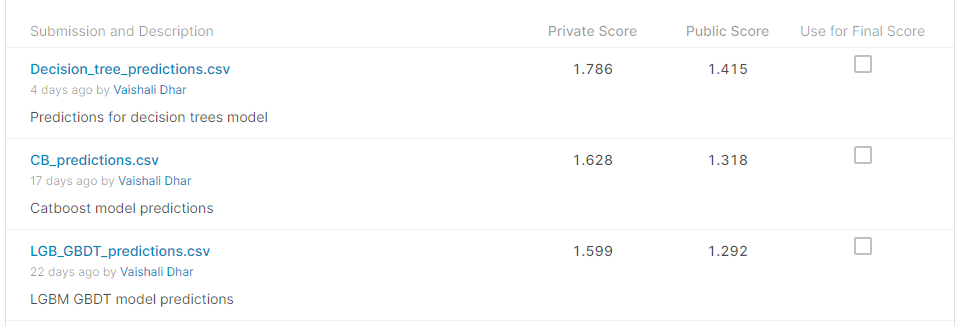